# Remote Sensing - Exploring Black Marble Imagery at Penn State

## Environment Setup

### Import Packages

In [1]:
# Import packages
import os
import re # in radiance.py
from collections import ChainMap # in radiance.py
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import numpy as np # in radiance.py
import pandas as pd # in radiance.py
from pandas.io.json import json_normalize # in radiance.py
import rasterio as rio # in radiance.py
from rasterio.plot import plotting_extent
from rasterio.transform import from_origin
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
import earthpy.mask as em # in radiance.py
import radiance as rd

### Set Package Options

In [2]:
# Set options
sns.set(font_scale=1.5)
np.set_printoptions(linewidth=np.inf)
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Set Working Directory

In [3]:
# Set working directory
working_directory = os.path.join(
    et.io.HOME, "PSU", "08-covid19-remote-sensing-fusion",
    "00-git-repos", "remote-sensing-fusion")

## Data Preparation

### Define File Paths

In [4]:
# Set path to radiance files
radiance_directory = os.path.join(
    working_directory, "02-raw-data", "PSU_BlackMarble_FallSemester2018_Onwards")

psu_lat_lon_path = os.path.join(
    radiance_directory, "PSU_Pixel_LatLongs.csv")

psu_radiance_path = os.path.join(
    radiance_directory, "PSU_Radiance_RavelOrderF_3.csv")

psu_cloud_mask_path = os.path.join(
    radiance_directory, "PSU_CloudMask_RavelOrderF_3.csv")

In [5]:
# Check that all paths to files exist
for path in [psu_lat_lon_path, psu_radiance_path, psu_cloud_mask_path]:
    print(f"Path exists: {path}") if os.path.exists(
        path) else print(f"Path does not exist: {path}")

Path exists: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\02-raw-data\PSU_BlackMarble_FallSemester2018_Onwards\PSU_Pixel_LatLongs.csv
Path exists: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\02-raw-data\PSU_BlackMarble_FallSemester2018_Onwards\PSU_Radiance_RavelOrderF_3.csv
Path exists: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\02-raw-data\PSU_BlackMarble_FallSemester2018_Onwards\PSU_CloudMask_RavelOrderF_3.csv


### Read CSV Files to Geodataframes

In [6]:
# Read lat/lon into dataframe
psu_lat_lon_df = pd.read_csv(psu_lat_lon_path)

In [7]:
# Display dataframe
psu_lat_lon_df.head()

,ID,Latitude,Longitude
0,0,40.829917,-77.937355
1,1,40.825751,-77.937355
2,2,40.821584,-77.937355
3,3,40.817417,-77.937355
4,4,40.813251,-77.937355


In [8]:
# Read radiance values to dataframe
psu_radiance_df = pd.read_csv(psu_radiance_path)

In [9]:
psu_radiance_df.head()

,2018-09-01,2018-09-02,2018-09-03,2018-09-04,2018-09-05,2018-09-06,2018-09-07,2018-09-08,2018-09-09,2018-09-10,2018-09-11,2018-09-12,2018-09-13,2018-09-14,2018-09-15,2018-09-16,2018-09-17,2018-09-18,2018-09-19,2018-09-20,2018-09-21,2018-09-22,2018-09-23,2018-09-24,2018-09-25,2018-09-26,2018-09-27,2018-09-28,2018-09-29,2018-09-30,2018-10-01,2018-10-02,2018-10-03,2018-10-04,2018-10-05,2018-10-06,2018-10-07,2018-10-08,2018-10-09,2018-10-10,2018-10-11,2018-10-12,2018-10-13,2018-10-14,2018-10-15,2018-10-16,2018-10-17,2018-10-18,2018-10-19,2018-10-20,2018-10-21,2018-10-22,2018-10-23,2018-10-24,2018-10-25,2018-10-26,2018-10-27,2018-10-28,2018-10-29,2018-10-30,2018-10-31,2018-11-01,2018-11-02,2018-11-03,2018-11-04,2018-11-05,2018-11-06,2018-11-07,2018-11-08,2018-11-09,2018-11-10,2018-11-11,2018-11-12,2018-11-13,2018-11-14,2018-11-15,2018-11-16,2018-11-17,2018-11-18,2018-11-19,2018-11-20,2018-11-21,2018-11-22,2018-11-23,2018-11-24,2018-11-25,2018-11-26,2018-11-27,2018-11-28,2018-11-29,2018-11-30,2018-12-01,2018-12-02,2018-12-03,2018-12-04,2018-12-05,2018-12-06,2018-12-07,2018-12-08,2018-12-09,2018-12-10,2018-12-11,2018-12-12,2018-12-13,2018-12-14,2018-12-15,2018-12-16,2018-12-17,2018-12-18,2018-12-19,2018-12-20,2018-12-21,2018-12-22,2018-12-23,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29,2018-12-30,2018-12-31,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-12,2019-01-13,2019-01-14,2019-01-15,2019-01-16,2019-01-17,2019-01-18,2019-01-19,2019-01-20,2019-01-21,2019-01-22,2019-01-23,2019-01-24,2019-01-25,2019-01-26,2019-01-27,2019-01-28,2019-01-29,2019-01-30,2019-01-31,2019-02-01,2019-02-02,2019-02-03,2019-02-04,2019-02-05,2019-02-06,2019-02-07,2019-02-08,2019-02-09,2019-02-10,2019-02-11,2019-02-12,2019-02-13,2019-02-14,2019-02-15,2019-02-16,2019-02-17,2019-02-18,2019-02-19,2019-02-20,2019-02-21,2019-02-22,2019-02-23,2019-02-24,2019-02-25,2019-02-26,2019-02-27,2019-02-28,2019-03-01,2019-03-02,2019-03-03,2019-03-04,2019-03-05,2019-03-06,2019-03-07,2019-03-08,2019-03-09,2019-03-10,2019-03-11,2019-03-12,2019-03-13,2019-03-14,2019-03-15,2019-03-16,2019-03-17,2019-03-18,2019-03-19,2019-03-20,2019-03-21,2019-03-22,2019-03-23,2019-03-24,2019-03-25,2019-03-26,2019-03-27,2019-03-28,2019-03-29,2019-03-30,2019-03-31,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-06,2019-04-07,2019-04-08,2019-04-09,2019-04-10,2019-04-11,2019-04-12,2019-04-13,2019-04-14,2019-04-15,2019-04-16,2019-04-17,2019-04-18,2019-04-19,2019-04-20,2019-04-21,2019-04-22,2019-04-23,2019-04-24,2019-04-25,2019-04-26,2019-04-27,2019-04-28,2019-04-29,2019-04-30,2019-05-01,2019-05-02,2019-05-03,2019-05-04,2019-05-05,2019-05-06,2019-05-07,2019-05-08,2019-05-09,2019-05-10,2019-05-11,2019-05-12,2019-05-13,2019-05-14,2019-05-15,2019-05-16,2019-05-17,2019-05-18,2019-05-19,2019-05-20,2019-05-21,2019-05-22,2019-05-23,2019-05-24,2019-05-25,2019-05-26,2019-05-27,2019-05-28,2019-05-29,2019-05-30,2019-05-31,2019-06-01,2019-06-02,2019-06-03,2019-06-04,2019-06-05,2019-06-06,2019-06-07,2019-06-08,2019-06-09,2019-06-10,2019-06-11,2019-06-12,2019-06-13,2019-06-14,2019-06-15,2019-06-20,2019-06-21,2019-06-22,2019-06-24,2019-06-25,2019-06-26,2019-06-27,2019-06-28,2019-06-29,2019-06-30,2019-07-01,2019-07-03,2019-07-04,2019-07-06,2019-07-07,2019-07-08,2019-07-11,2019-07-12,2019-07-14,2019-07-15,2019-07-16,2019-07-17,2019-07-18,2019-07-19,2019-07-20,2019-07-21,2019-07-22,2019-07-23,2019-07-24,2019-07-25,2019-07-26,2019-07-27,2019-07-28,2019-07-29,2019-07-31,2019-08-03,2019-08-04,2019-08-05,2019-08-06,2019-08-09,2019-08-10,2019-08-11,2019-08-12,2019-08-14,2019-08-15,2019-08-16,2019-08-17,2019-08-18,2019-08-19,2019-08-20,2019-08-21,2019-08-22,2019-08-23,2019-08-24,2019-08-25,2019-08-26,2019-08-28,2019-08-29,2019-08-30,2019-08-31,2019-09-01,2019-09-02,2019-09-03,2019-09-04,2019-09-05,2019-09-06,2019-09-07,2019-09-08,2019-09-11,2019-09-12,2019-09-13,2019-09-14,2019-09-15,2019-09-17,2019-09-18,2019-0

In [10]:
# Read cloud mask values to dataframe
psu_cloud_mask_df = pd.read_csv(psu_cloud_mask_path)

In [11]:
psu_cloud_mask_df.head()

,2018-09-01,2018-09-02,2018-09-03,2018-09-04,2018-09-05,2018-09-06,2018-09-07,2018-09-08,2018-09-09,2018-09-10,2018-09-11,2018-09-12,2018-09-13,2018-09-14,2018-09-15,2018-09-16,2018-09-17,2018-09-18,2018-09-19,2018-09-20,2018-09-21,2018-09-22,2018-09-23,2018-09-24,2018-09-25,2018-09-26,2018-09-27,2018-09-28,2018-09-29,2018-09-30,2018-10-01,2018-10-02,2018-10-03,2018-10-04,2018-10-05,2018-10-06,2018-10-07,2018-10-08,2018-10-09,2018-10-10,2018-10-11,2018-10-12,2018-10-13,2018-10-14,2018-10-15,2018-10-16,2018-10-17,2018-10-18,2018-10-19,2018-10-20,2018-10-21,2018-10-22,2018-10-23,2018-10-24,2018-10-25,2018-10-26,2018-10-27,2018-10-28,2018-10-29,2018-10-30,2018-10-31,2018-11-01,2018-11-02,2018-11-03,2018-11-04,2018-11-05,2018-11-06,2018-11-07,2018-11-08,2018-11-09,2018-11-10,2018-11-11,2018-11-12,2018-11-13,2018-11-14,2018-11-15,2018-11-16,2018-11-17,2018-11-18,2018-11-19,2018-11-20,2018-11-21,2018-11-22,2018-11-23,2018-11-24,2018-11-25,2018-11-26,2018-11-27,2018-11-28,2018-11-29,2018-11-30,2018-12-01,2018-12-02,2018-12-03,2018-12-04,2018-12-05,2018-12-06,2018-12-07,2018-12-08,2018-12-09,2018-12-10,2018-12-11,2018-12-12,2018-12-13,2018-12-14,2018-12-15,2018-12-16,2018-12-17,2018-12-18,2018-12-19,2018-12-20,2018-12-21,2018-12-22,2018-12-23,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29,2018-12-30,2018-12-31,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-12,2019-01-13,2019-01-14,2019-01-15,2019-01-16,2019-01-17,2019-01-18,2019-01-19,2019-01-20,2019-01-21,2019-01-22,2019-01-23,2019-01-24,2019-01-25,2019-01-26,2019-01-27,2019-01-28,2019-01-29,2019-01-30,2019-01-31,2019-02-01,2019-02-02,2019-02-03,2019-02-04,2019-02-05,2019-02-06,2019-02-07,2019-02-08,2019-02-09,2019-02-10,2019-02-11,2019-02-12,2019-02-13,2019-02-14,2019-02-15,2019-02-16,2019-02-17,2019-02-18,2019-02-19,2019-02-20,2019-02-21,2019-02-22,2019-02-23,2019-02-24,2019-02-25,2019-02-26,2019-02-27,2019-02-28,2019-03-01,2019-03-02,2019-03-03,2019-03-04,2019-03-05,2019-03-06,2019-03-07,2019-03-08,2019-03-09,2019-03-10,2019-03-11,2019-03-12,2019-03-13,2019-03-14,2019-03-15,2019-03-16,2019-03-17,2019-03-18,2019-03-19,2019-03-20,2019-03-21,2019-03-22,2019-03-23,2019-03-24,2019-03-25,2019-03-26,2019-03-27,2019-03-28,2019-03-29,2019-03-30,2019-03-31,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-06,2019-04-07,2019-04-08,2019-04-09,2019-04-10,2019-04-11,2019-04-12,2019-04-13,2019-04-14,2019-04-15,2019-04-16,2019-04-17,2019-04-18,2019-04-19,2019-04-20,2019-04-21,2019-04-22,2019-04-23,2019-04-24,2019-04-25,2019-04-26,2019-04-27,2019-04-28,2019-04-29,2019-04-30,2019-05-01,2019-05-02,2019-05-03,2019-05-04,2019-05-05,2019-05-06,2019-05-07,2019-05-08,2019-05-09,2019-05-10,2019-05-11,2019-05-12,2019-05-13,2019-05-14,2019-05-15,2019-05-16,2019-05-17,2019-05-18,2019-05-19,2019-05-20,2019-05-21,2019-05-22,2019-05-23,2019-05-24,2019-05-25,2019-05-26,2019-05-27,2019-05-28,2019-05-29,2019-05-30,2019-05-31,2019-06-01,2019-06-02,2019-06-03,2019-06-04,2019-06-05,2019-06-06,2019-06-07,2019-06-08,2019-06-09,2019-06-10,2019-06-11,2019-06-12,2019-06-13,2019-06-14,2019-06-15,2019-06-20,2019-06-21,2019-06-22,2019-06-24,2019-06-25,2019-06-26,2019-06-27,2019-06-28,2019-06-29,2019-06-30,2019-07-01,2019-07-03,2019-07-04,2019-07-06,2019-07-07,2019-07-08,2019-07-11,2019-07-12,2019-07-14,2019-07-15,2019-07-16,2019-07-17,2019-07-18,2019-07-19,2019-07-20,2019-07-21,2019-07-22,2019-07-23,2019-07-24,2019-07-25,2019-07-26,2019-07-27,2019-07-28,2019-07-29,2019-07-31,2019-08-03,2019-08-04,2019-08-05,2019-08-06,2019-08-09,2019-08-10,2019-08-11,2019-08-12,2019-08-14,2019-08-15,2019-08-16,2019-08-17,2019-08-18,2019-08-19,2019-08-20,2019-08-21,2019-08-22,2019-08-23,2019-08-24,2019-08-25,2019-08-26,2019-08-28,2019-08-29,2019-08-30,2019-08-31,2019-09-01,2019-09-02,2019-09-03,2019-09-04,2019-09-05,2019-09-06,2019-09-07,2019-09-08,2019-09-11,2019-09-12,2019-09-13,2019-09-14,2019-09-15,2019-09-17,2019-09-18,2019-0

### Add Missings Dates and Data

In [12]:
# Fill radiance data with missing dates (dates specified by user)
psu_radiance_filled = rd.add_missing_data(
    psu_radiance_df, '2018-09-01', '2020-05-07')

In [13]:
# Display dataset with filled data (NaN)
psu_radiance_filled.head()

,2018-09-01,2018-09-02,2018-09-03,2018-09-04,2018-09-05,2018-09-06,2018-09-07,2018-09-08,2018-09-09,2018-09-10,2018-09-11,2018-09-12,2018-09-13,2018-09-14,2018-09-15,2018-09-16,2018-09-17,2018-09-18,2018-09-19,2018-09-20,2018-09-21,2018-09-22,2018-09-23,2018-09-24,2018-09-25,2018-09-26,2018-09-27,2018-09-28,2018-09-29,2018-09-30,2018-10-01,2018-10-02,2018-10-03,2018-10-04,2018-10-05,2018-10-06,2018-10-07,2018-10-08,2018-10-09,2018-10-10,2018-10-11,2018-10-12,2018-10-13,2018-10-14,2018-10-15,2018-10-16,2018-10-17,2018-10-18,2018-10-19,2018-10-20,2018-10-21,2018-10-22,2018-10-23,2018-10-24,2018-10-25,2018-10-26,2018-10-27,2018-10-28,2018-10-29,2018-10-30,2018-10-31,2018-11-01,2018-11-02,2018-11-03,2018-11-04,2018-11-05,2018-11-06,2018-11-07,2018-11-08,2018-11-09,2018-11-10,2018-11-11,2018-11-12,2018-11-13,2018-11-14,2018-11-15,2018-11-16,2018-11-17,2018-11-18,2018-11-19,2018-11-20,2018-11-21,2018-11-22,2018-11-23,2018-11-24,2018-11-25,2018-11-26,2018-11-27,2018-11-28,2018-11-29,2018-11-30,2018-12-01,2018-12-02,2018-12-03,2018-12-04,2018-12-05,2018-12-06,2018-12-07,2018-12-08,2018-12-09,2018-12-10,2018-12-11,2018-12-12,2018-12-13,2018-12-14,2018-12-15,2018-12-16,2018-12-17,2018-12-18,2018-12-19,2018-12-20,2018-12-21,2018-12-22,2018-12-23,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29,2018-12-30,2018-12-31,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-12,2019-01-13,2019-01-14,2019-01-15,2019-01-16,2019-01-17,2019-01-18,2019-01-19,2019-01-20,2019-01-21,2019-01-22,2019-01-23,2019-01-24,2019-01-25,2019-01-26,2019-01-27,2019-01-28,2019-01-29,2019-01-30,2019-01-31,2019-02-01,2019-02-02,2019-02-03,2019-02-04,2019-02-05,2019-02-06,2019-02-07,2019-02-08,2019-02-09,2019-02-10,2019-02-11,2019-02-12,2019-02-13,2019-02-14,2019-02-15,2019-02-16,2019-02-17,2019-02-18,2019-02-19,2019-02-20,2019-02-21,2019-02-22,2019-02-23,2019-02-24,2019-02-25,2019-02-26,2019-02-27,2019-02-28,2019-03-01,2019-03-02,2019-03-03,2019-03-04,2019-03-05,2019-03-06,2019-03-07,2019-03-08,2019-03-09,2019-03-10,2019-03-11,2019-03-12,2019-03-13,2019-03-14,2019-03-15,2019-03-16,2019-03-17,2019-03-18,2019-03-19,2019-03-20,2019-03-21,2019-03-22,2019-03-23,2019-03-24,2019-03-25,2019-03-26,2019-03-27,2019-03-28,2019-03-29,2019-03-30,2019-03-31,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-06,2019-04-07,2019-04-08,2019-04-09,2019-04-10,2019-04-11,2019-04-12,2019-04-13,2019-04-14,2019-04-15,2019-04-16,2019-04-17,2019-04-18,2019-04-19,2019-04-20,2019-04-21,2019-04-22,2019-04-23,2019-04-24,2019-04-25,2019-04-26,2019-04-27,2019-04-28,2019-04-29,2019-04-30,2019-05-01,2019-05-02,2019-05-03,2019-05-04,2019-05-05,2019-05-06,2019-05-07,2019-05-08,2019-05-09,2019-05-10,2019-05-11,2019-05-12,2019-05-13,2019-05-14,2019-05-15,2019-05-16,2019-05-17,2019-05-18,2019-05-19,2019-05-20,2019-05-21,2019-05-22,2019-05-23,2019-05-24,2019-05-25,2019-05-26,2019-05-27,2019-05-28,2019-05-29,2019-05-30,2019-05-31,2019-06-01,2019-06-02,2019-06-03,2019-06-04,2019-06-05,2019-06-06,2019-06-07,2019-06-08,2019-06-09,2019-06-10,2019-06-11,2019-06-12,2019-06-13,2019-06-14,2019-06-15,2019-06-16,2019-06-17,2019-06-18,2019-06-19,2019-06-20,2019-06-21,2019-06-22,2019-06-23,2019-06-24,2019-06-25,2019-06-26,2019-06-27,2019-06-28,2019-06-29,2019-06-30,2019-07-01,2019-07-02,2019-07-03,2019-07-04,2019-07-05,2019-07-06,2019-07-07,2019-07-08,2019-07-09,2019-07-10,2019-07-11,2019-07-12,2019-07-13,2019-07-14,2019-07-15,2019-07-16,2019-07-17,2019-07-18,2019-07-19,2019-07-20,2019-07-21,2019-07-22,2019-07-23,2019-07-24,2019-07-25,2019-07-26,2019-07-27,2019-07-28,2019-07-29,2019-07-30,2019-07-31,2019-08-01,2019-08-02,2019-08-03,2019-08-04,2019-08-05,2019-08-06,2019-08-07,2019-08-08,2019-08-09,2019-08-10,2019-08-11,2019-08-12,2019-08-13,2019-08-14,2019-08-15,2019-08-16,2019-08-17,2019-08-18,2019-08-19,2019-08-20,2019-08-21,2019-08-22,2019-08-23,2019-08-24,2019-08-25,2019-08-26,2019-08-27,2019-08-28,2019-08-29,2019-0

In [14]:
# Fill cloud mask data with missing dates
psu_cloud_mask_filled = rd.add_missing_data(
    psu_cloud_mask_df, '2018-09-01', '2020-05-07')

In [15]:
# Display filled dataset with filled data (NaN)
psu_cloud_mask_filled.head()

,2018-09-01,2018-09-02,2018-09-03,2018-09-04,2018-09-05,2018-09-06,2018-09-07,2018-09-08,2018-09-09,2018-09-10,2018-09-11,2018-09-12,2018-09-13,2018-09-14,2018-09-15,2018-09-16,2018-09-17,2018-09-18,2018-09-19,2018-09-20,2018-09-21,2018-09-22,2018-09-23,2018-09-24,2018-09-25,2018-09-26,2018-09-27,2018-09-28,2018-09-29,2018-09-30,2018-10-01,2018-10-02,2018-10-03,2018-10-04,2018-10-05,2018-10-06,2018-10-07,2018-10-08,2018-10-09,2018-10-10,2018-10-11,2018-10-12,2018-10-13,2018-10-14,2018-10-15,2018-10-16,2018-10-17,2018-10-18,2018-10-19,2018-10-20,2018-10-21,2018-10-22,2018-10-23,2018-10-24,2018-10-25,2018-10-26,2018-10-27,2018-10-28,2018-10-29,2018-10-30,2018-10-31,2018-11-01,2018-11-02,2018-11-03,2018-11-04,2018-11-05,2018-11-06,2018-11-07,2018-11-08,2018-11-09,2018-11-10,2018-11-11,2018-11-12,2018-11-13,2018-11-14,2018-11-15,2018-11-16,2018-11-17,2018-11-18,2018-11-19,2018-11-20,2018-11-21,2018-11-22,2018-11-23,2018-11-24,2018-11-25,2018-11-26,2018-11-27,2018-11-28,2018-11-29,2018-11-30,2018-12-01,2018-12-02,2018-12-03,2018-12-04,2018-12-05,2018-12-06,2018-12-07,2018-12-08,2018-12-09,2018-12-10,2018-12-11,2018-12-12,2018-12-13,2018-12-14,2018-12-15,2018-12-16,2018-12-17,2018-12-18,2018-12-19,2018-12-20,2018-12-21,2018-12-22,2018-12-23,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29,2018-12-30,2018-12-31,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-12,2019-01-13,2019-01-14,2019-01-15,2019-01-16,2019-01-17,2019-01-18,2019-01-19,2019-01-20,2019-01-21,2019-01-22,2019-01-23,2019-01-24,2019-01-25,2019-01-26,2019-01-27,2019-01-28,2019-01-29,2019-01-30,2019-01-31,2019-02-01,2019-02-02,2019-02-03,2019-02-04,2019-02-05,2019-02-06,2019-02-07,2019-02-08,2019-02-09,2019-02-10,2019-02-11,2019-02-12,2019-02-13,2019-02-14,2019-02-15,2019-02-16,2019-02-17,2019-02-18,2019-02-19,2019-02-20,2019-02-21,2019-02-22,2019-02-23,2019-02-24,2019-02-25,2019-02-26,2019-02-27,2019-02-28,2019-03-01,2019-03-02,2019-03-03,2019-03-04,2019-03-05,2019-03-06,2019-03-07,2019-03-08,2019-03-09,2019-03-10,2019-03-11,2019-03-12,2019-03-13,2019-03-14,2019-03-15,2019-03-16,2019-03-17,2019-03-18,2019-03-19,2019-03-20,2019-03-21,2019-03-22,2019-03-23,2019-03-24,2019-03-25,2019-03-26,2019-03-27,2019-03-28,2019-03-29,2019-03-30,2019-03-31,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-06,2019-04-07,2019-04-08,2019-04-09,2019-04-10,2019-04-11,2019-04-12,2019-04-13,2019-04-14,2019-04-15,2019-04-16,2019-04-17,2019-04-18,2019-04-19,2019-04-20,2019-04-21,2019-04-22,2019-04-23,2019-04-24,2019-04-25,2019-04-26,2019-04-27,2019-04-28,2019-04-29,2019-04-30,2019-05-01,2019-05-02,2019-05-03,2019-05-04,2019-05-05,2019-05-06,2019-05-07,2019-05-08,2019-05-09,2019-05-10,2019-05-11,2019-05-12,2019-05-13,2019-05-14,2019-05-15,2019-05-16,2019-05-17,2019-05-18,2019-05-19,2019-05-20,2019-05-21,2019-05-22,2019-05-23,2019-05-24,2019-05-25,2019-05-26,2019-05-27,2019-05-28,2019-05-29,2019-05-30,2019-05-31,2019-06-01,2019-06-02,2019-06-03,2019-06-04,2019-06-05,2019-06-06,2019-06-07,2019-06-08,2019-06-09,2019-06-10,2019-06-11,2019-06-12,2019-06-13,2019-06-14,2019-06-15,2019-06-16,2019-06-17,2019-06-18,2019-06-19,2019-06-20,2019-06-21,2019-06-22,2019-06-23,2019-06-24,2019-06-25,2019-06-26,2019-06-27,2019-06-28,2019-06-29,2019-06-30,2019-07-01,2019-07-02,2019-07-03,2019-07-04,2019-07-05,2019-07-06,2019-07-07,2019-07-08,2019-07-09,2019-07-10,2019-07-11,2019-07-12,2019-07-13,2019-07-14,2019-07-15,2019-07-16,2019-07-17,2019-07-18,2019-07-19,2019-07-20,2019-07-21,2019-07-22,2019-07-23,2019-07-24,2019-07-25,2019-07-26,2019-07-27,2019-07-28,2019-07-29,2019-07-30,2019-07-31,2019-08-01,2019-08-02,2019-08-03,2019-08-04,2019-08-05,2019-08-06,2019-08-07,2019-08-08,2019-08-09,2019-08-10,2019-08-11,2019-08-12,2019-08-13,2019-08-14,2019-08-15,2019-08-16,2019-08-17,2019-08-18,2019-08-19,2019-08-20,2019-08-21,2019-08-22,2019-08-23,2019-08-24,2019-08-25,2019-08-26,2019-08-27,2019-08-28,2019-08-29,2019-0

### Extract Plotting Extent & Transform

In [16]:
# Extract PSU extent and transform from lat/lon dataframe
psu_extent, psu_transform, psu_shape = rd.extract_extent(
    study_area=psu_lat_lon_df, 
    longitude_column='Longitude', 
    latitude_column='Latitude')

In [17]:
# Display extent (left, right, bottom, top)
psu_extent

(-77.93735504, -77.77068837333334, 40.754917322941175, 40.82991733)

In [18]:
# Display tranform (used for export)
psu_transform

Affine(0.004166666666666521, 0.0, -77.93735504,
       0.0, -0.004166667058823534, 40.82991733)

In [19]:
# Display shape
psu_shape

(18, 40)

### Create GeoDataFrame of Lat/Lon Points

In [20]:
# Create geodataframe to store lat/lon points 
#  (for plotting over array)
psu_lat_lon_copy = psu_lat_lon_df.copy()

psu_lat_lon_gdf = gpd.GeoDataFrame(
    psu_lat_lon_copy, 
    crs="epsg:4326", 
    geometry=gpd.points_from_xy(
        psu_lat_lon_copy.Longitude, 
        psu_lat_lon_copy.Latitude)
)

In [21]:
# Display dataframe
psu_lat_lon_gdf.head()

,ID,Latitude,Longitude,geometry
0,0,40.829917,-77.937355,POINT (-77.93736 40.82992)
1,1,40.825751,-77.937355,POINT (-77.93736 40.82575)
2,2,40.821584,-77.937355,POINT (-77.93736 40.82158)
3,3,40.817417,-77.937355,POINT (-77.93736 40.81742)
4,4,40.813251,-77.937355,POINT (-77.93736 40.81325)


## Data Processing

**Penn State Academic Calendars**

[All Academic Calendars](http://www.registrar.psu.edu/academic-calendars/)

[2018-2019 Academic Calendar](http://www.registrar.psu.edu/academic-calendars/2018-19.cfm)

[2019-2020 Academic Calendar](http://www.registrar.psu.edu/academic-calendars/2019-20.cfm)

### Store Daily Radiance Values

In [22]:
# Get list of dates (daily) from Sept 1, 2018 to May 7, 2020
date_list = rd.create_date_list(start_date='2018-09-01', end_date='2020-05-07')

In [23]:
# Display number of days in list
len(date_list)

615

In [24]:
# Store all daily filled values in nested dictionary
#  (indexed by [Year][Month][Day])
radiance_sept_2018_may_2020 = rd.store_data(
    psu_radiance_filled, psu_cloud_mask_filled, 
    mask_value=100, array_shape=psu_shape, dates=date_list)

In [25]:
# Initialize counters for years/months/days in dictionary
years = months = days = 0
radiance_dict = radiance_sept_2018_may_2020

# Loop through all years
for key_year in radiance_dict.keys():

    # Add to counter for each year
    years += 1
    
    # Loop through all months
    for key_month in radiance_dict.get(key_year).keys():
        
        # Add to counter for each month
        months += 1
        
        # Loop through all days
        for key_day in radiance_dict.get(key_year).get(key_month):
        
            # Add to counter for each day
            days += 1

In [26]:
# Display number of years/months/days in dictionary
print(f"Entries in Radiance Dictionary\nYears:    {years}\nMonths:  {months}\nDays:   {days}")

Entries in Radiance Dictionary
Years:    3
Months:  21
Days:   615


### Date Range Radiance - Monthly Mean Radiance

In [50]:
# Define year/month combinations to loop through
calendar_months_2018_2020 = [
    '2018-09', '2018-10', '2018-11', '2018-12',
    '2019-01', '2019-02', '2019-03', '2019-04',
    '2019-05', '2019-06', '2019-07', '2019-08',
    '2019-09', '2019-10', '2019-11', '2019-12',
    '2020-01', '2020-02', '2020-03', '2020-04'
]

In [51]:
# Store monthly means in dictionary
radiance_monthtly_mean = rd.store_monthly_mean(
    radiance_daily=radiance_sept_2018_may_2020, 
    dates=calendar_months_2018_2020)

In [52]:
# Show top-level keys (years)
radiance_monthtly_mean.keys()

dict_keys(['2018', '2019', '2020'])

In [53]:
# Show 2018 keys (months)
radiance_monthtly_mean.get('2018').keys()

dict_keys(['09', '10', '11', '12'])

In [54]:
# Show 2019 keys (months)
radiance_monthtly_mean.get('2019').keys()

dict_keys(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'])

In [55]:
# Show 2020 keys (months)
radiance_monthtly_mean.get('2020').keys()

dict_keys(['01', '02', '03', '04'])

In [33]:
# Get min and max values for September 2019 mean
print(f"Min Radiance, Sept 2019 Mean Values: {radiance_monthtly_mean.get('2019').get('09').min()}")
print(f"Max Radiance, Sept 2019 Mean Values: {radiance_monthtly_mean.get('2019').get('09').max()}")

Min Radiance, Sept 2019 Mean Values: 21.565217391304348
Max Radiance, Sept 2019 Mean Values: 611.1739130434783


In [34]:
# Get min and max values for March 2020 mean
print(f"Min Radiance, March 2020 Mean Values: {radiance_monthtly_mean.get('2020').get('03').min()}")
print(f"Max Radiance, March 2020 Mean Values: {radiance_monthtly_mean.get('2020').get('03').max()}")

Min Radiance, March 2020 Mean Values: 21.741935483870968
Max Radiance, March 2020 Mean Values: 430.03225806451616


### Date Range Radiance Mean - Continuous Date Ranges

In [36]:
# Define date ranges (start date, end date) to loop through
academic_years_2018_2020 = [

    # Labor day weekend to commencement weekend (includes day after commencement)
    ('2018-09-01', '2018-12-16'),

    # Thanksgiving holiday
    ('2018-11-18', '2018-11-24'),

    # Fall study days & final exam week
    ('2018-12-08', '2018-12-14'),

    # After Fall commencement to before Spring new student arrival
    ('2018-12-17', '2019-01-04'),

    # Spring new student arrival to Spring commencement (commencement weekend)
    ('2019-01-05', '2019-05-05'),

    # Spring break
    ('2019-03-03', '2019-03-09'),

    # Spring study days & final exam week
    ('2019-04-27', '2019-05-03'),

    # Maymester (excluding arrival day, which occurs on Spring commencement)
    ('2019-05-06', '2019-06-05'),

    # Summer session (regular) through commencement (includes day after commencement)
    ('2019-05-12', '2019-08-11'),


    # 2019-2020 academic year
    # Fall new student arrival to commencement weekend (includes day after commencement)
    ('2019-08-23', '2019-12-22'),

    # Labor day weekend to Commencement weekend (includes day after commencement)
    ('2019-08-31', '2019-12-22'),

    # Thanksgiving holiday
    ('2019-11-24', '2019-11-30'),

    # Fall study days & final exam week
    ('2019-12-14', '2019-12-20'),

    # After Fall commencement to before Spring new student arrival
    ('2019-12-23', '2020-01-10'),

    # Spring new student arrival to Spring commencement (commencement weekend)
    ('2020-01-11', '2020-05-10'),

    # Spring break
    ('2020-03-08', '2020-03-14'),

    # Spring study days & final exam week
    ('2020-05-02', '2020-05-08')

    #     # Maymester (excluding arrival day, which occurs on Spring commencement)
    #     rd.create_date_list('2020-05-11', '2020-06-10'),

    #     # Summer session (regular) through commencement (includes day after commencement)
    #     rd.create_date_list('2020-05-18', '2020-08-15')
]

In [37]:
# Store continuous ranges means in dictionary
academic_years_2018_2020_means = rd.store_continuous_range_mean(
    radiance_daily=radiance_sept_2018_may_2020,
    date_range_list=academic_years_2018_2020)

In [59]:
# Show all keys in dictionary
for key in academic_years_2018_2020_means.keys():
    print(key)

20180901-20181216
20181118-20181124
20181208-20181214
20181217-20190104
20190105-20190505
20190303-20190309
20190427-20190503
20190506-20190605
20190512-20190811
20190823-20191222
20190831-20191222
20191124-20191130
20191214-20191220
20191223-20200110
20200111-20200510
20200308-20200314
20200502-20200508


In [39]:
# Display number of keys
len(academic_years_2018_2020_means.keys())

17

In [40]:
# Display shape of single mean array in dictionary
academic_years_2018_2020_means.get('20190512-20190811').shape

(18, 40)

### Date Range Radiance - Recurring Weekly Day Means (SUN, MON, TUE, etc.)

In [41]:
# Define date ranges for academic semesters
semester_ranges = [
    
    # Fall 2018
    ('2018-09-01', '2018-12-16'),
    
    # Spring 2019
    ('2019-01-05', '2019-05-05'),

    # Summer 2019
    ('2019-05-12', '2019-08-11'),
    
    # Fall 2019
    ('2019-08-31', '2019-12-22'),
    
    # Spring 2020
    ('2020-01-11', '2020-05-10')
]

In [42]:
# Create list of dictionaries with stored semester weekly radiances
semesters_weekly = [rd.store_weekly_range_mean(radiance_sept_2018_may_2020, start_date, end_date)
                    for start_date, end_date in semester_ranges]

In [58]:
# Unpack list of dictionaries to single dictionary
semesters_unpacked = rd.unpack_dictionaries(semesters_weekly)

# Display all keys in unpacked dictionary
for key in semesters_unpacked.keys():
    print(key)

20180901-20181216-SUN
20180901-20181216-MON
20180901-20181216-TUE
20180901-20181216-WED
20180901-20181216-THU
20180901-20181216-FRI
20180901-20181216-SAT
20180901-20181216-BUS
20190105-20190505-SUN
20190105-20190505-MON
20190105-20190505-TUE
20190105-20190505-WED
20190105-20190505-THU
20190105-20190505-FRI
20190105-20190505-SAT
20190105-20190505-BUS
20190512-20190811-SUN
20190512-20190811-MON
20190512-20190811-TUE
20190512-20190811-WED
20190512-20190811-THU
20190512-20190811-FRI
20190512-20190811-SAT
20190512-20190811-BUS
20190831-20191222-SUN
20190831-20191222-MON
20190831-20191222-TUE
20190831-20191222-WED
20190831-20191222-THU
20190831-20191222-FRI
20190831-20191222-SAT
20190831-20191222-BUS
20200111-20200510-SUN
20200111-20200510-MON
20200111-20200510-TUE
20200111-20200510-WED
20200111-20200510-THU
20200111-20200510-FRI
20200111-20200510-SAT
20200111-20200510-BUS


In [44]:
# Display number of keys
len(semesters_unpacked.keys())

40

In [45]:
# Display shape of single mean array in dictionary
semesters_unpacked.get('20190831-20191222-MON').shape

(18, 40)

## Data Visualization

### Plot and Save Figures to PNG

Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-mean-sept-2019-values.png


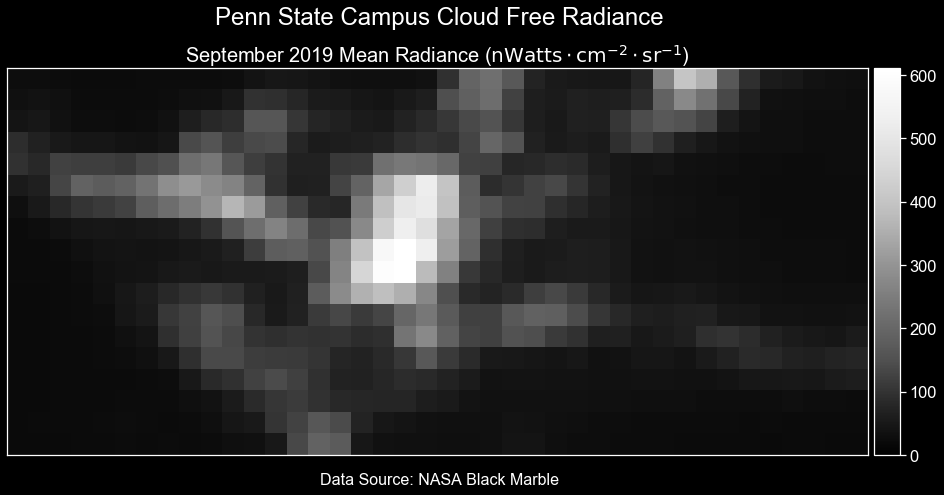

In [66]:
# Plot Sept 2019 mean
fig, ax = rd.plot_values(
    radiance_monthtly_mean.get('2019').get('09'),
    title="September 2019 Mean Radiance",
    difference=False)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-mean-sep-2019-values.png")

# Save figure as PNG
rd.save_figure(outpath)

Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-mean-sept-2019-histogram.png


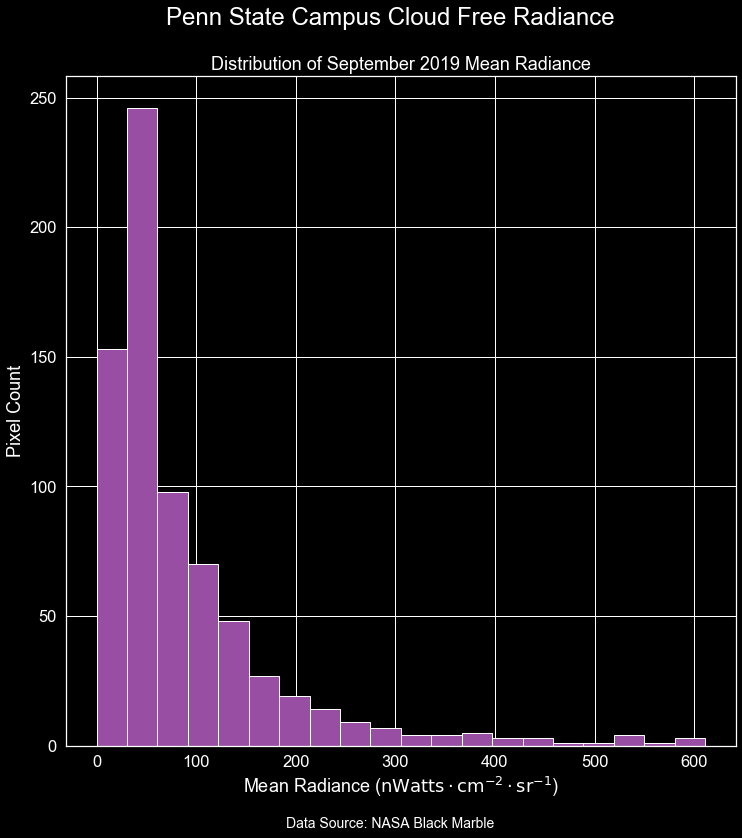

In [65]:
# Plot Sept 2019 histogram
fig, ax = rd.plot_histogram(
    radiance_monthtly_mean.get('2019').get('09'), 
    title="Distribution of September 2019 Mean Radiance",
    xlabel='Mean Radiance',
    difference=False)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-mean-sep-2019-histogram.png")

# Save figure as PNG
rd.save_figure(outpath)

Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-mean-march-2020-values.png


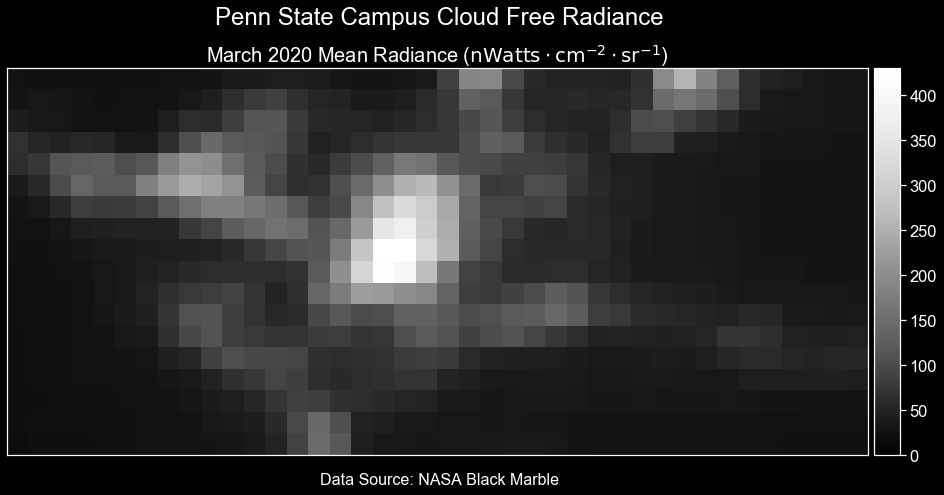

In [67]:
# Plot March 2020 mean
fig, ax = rd.plot_values(
    radiance_monthtly_mean.get('2020').get('03'), 
    title="March 2020 Mean Radiance",
    difference=False)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-mean-mar-2020-values.png")

# Save figure as PNG
rd.save_figure(outpath)

Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-mean-march-2020-histogram.png


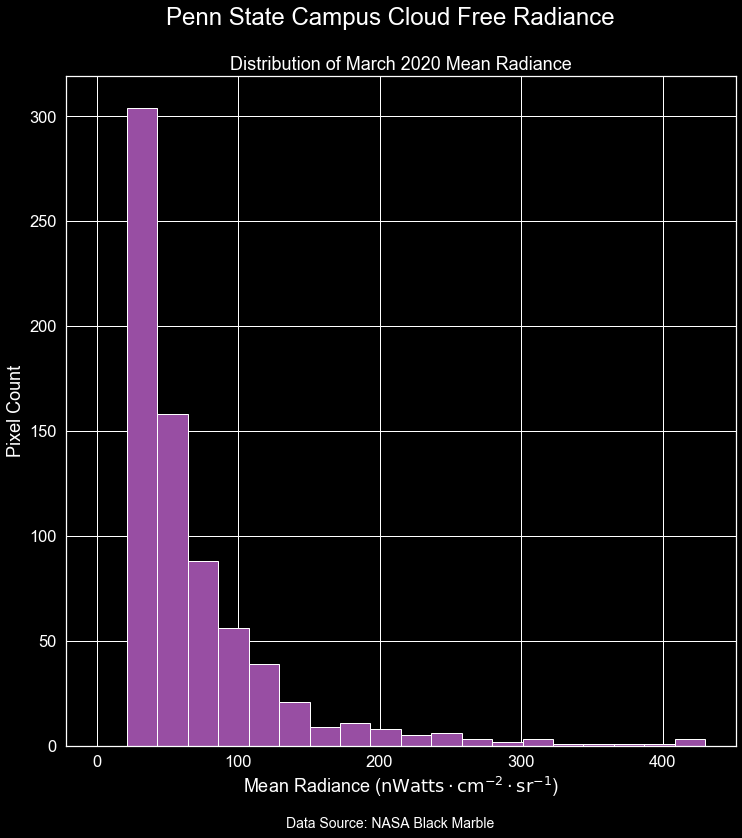

In [68]:
# Plot March 2020 histogram
fig, ax = rd.plot_histogram(
    radiance_monthtly_mean.get('2020').get('03'), 
    title="Distribution of March 2020 Mean Radiance",
    xlabel='Mean Radiance',
    difference=False)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-mean-mar-2020-histogram.png")

# Save figure as PNG
rd.save_figure(outpath)

Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-sept-2019-march-2020-values.png


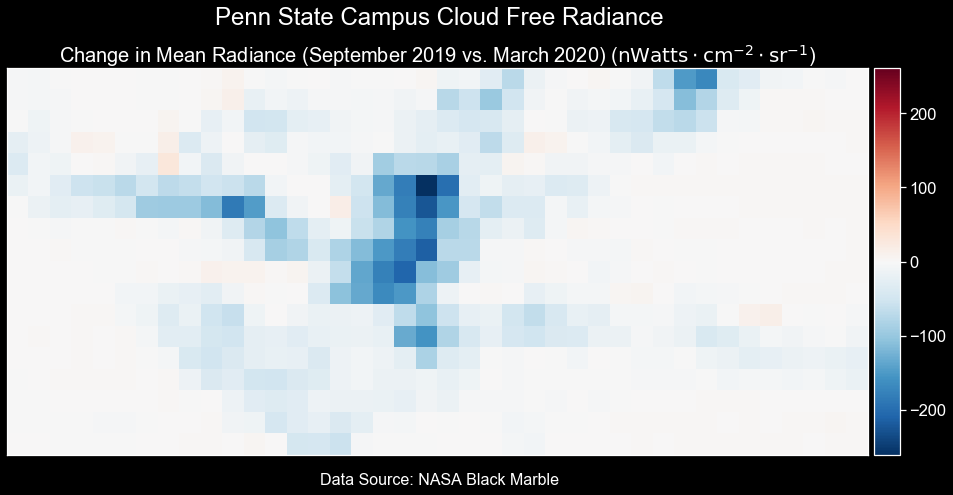

In [69]:
# Calculate change, September 2019 mean to March 2020 mean
diff_sep_2019_march_2020 = rd.subtract_arrays(
    radiance_monthtly_mean.get('2020').get('03'),
    radiance_monthtly_mean.get('2019').get('09'))

# Plot difference from Sept 2019 to March 2020
fig, ax = rd.plot_values(
    diff_sep_2019_march_2020, 
    title="Change in Mean Radiance (September 2019 vs. March 2020)",
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-sep-2019-mar-2020-values.png")

# Save figure as PNG
rd.save_figure(outpath)

Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-sept-2019-march-2020-histogram.png


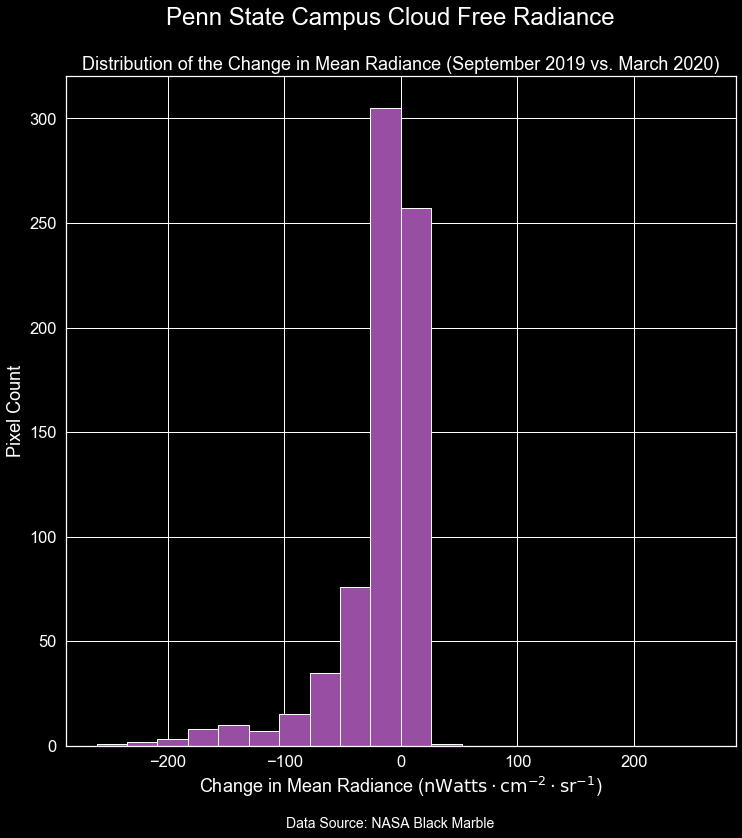

In [70]:
# Plot Sept 2019 vs. March 2020 change histogram
fig, ax = rd.plot_histogram(
    diff_sep_2019_march_2020, 
    title="Distribution of the Change in Mean Radiance (September 2019 vs. March 2020)",
    xlabel='Change in Mean Radiance',
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-sep-2019-mar-2020-histogram.png")

# Save figure as PNG
rd.save_figure(outpath)

### Plot and Save Figures to PNG - Monthly Mean Difference, 1 Year Gap

Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-sept-2018-sept-2019-values.png
Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-sept-2018-sept-2019-histogram.png


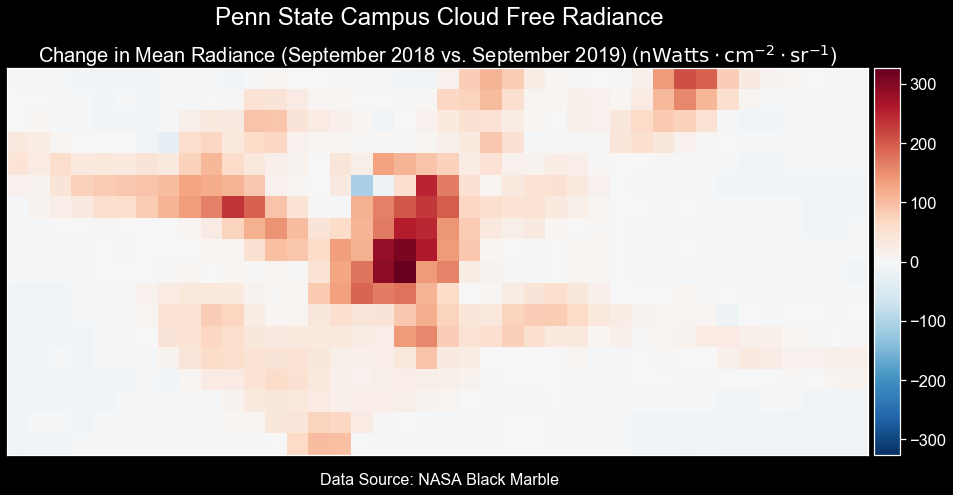

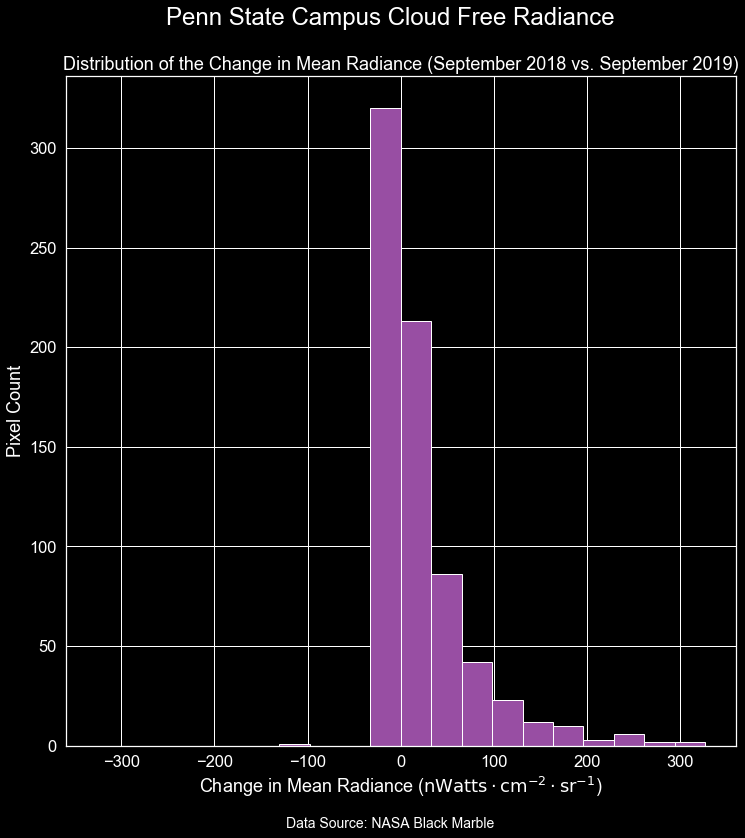

In [72]:
# Calculate September 2018 to September 2019 difference
diff_sep_2018_sep_2019 = rd.subtract_arrays(
    radiance_monthtly_mean.get('2019').get('09'),
    radiance_monthtly_mean.get('2018').get('09'))

# Plot difference
fig, ax = rd.plot_values(
    diff_sep_2018_sep_2019, 
    title="Change in Mean Radiance (September 2018 vs. September 2019)",
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-sep-2018-sep-2019-values.png")

# Save figure as PNG
rd.save_figure(outpath)

# Plot histogram
fig, ax = rd.plot_histogram(
    diff_sep_2018_sep_2019, 
    title="Distribution of the Change in Mean Radiance (September 2018 vs. September 2019)",
    xlabel='Change in Mean Radiance',
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-sep-2018-sep-2019-histogram.png")

# Save figure as PNG
rd.save_figure(outpath)

Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-oct-2018-oct-2019-values.png
Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-oct-2018-oct-2019-histogram.png


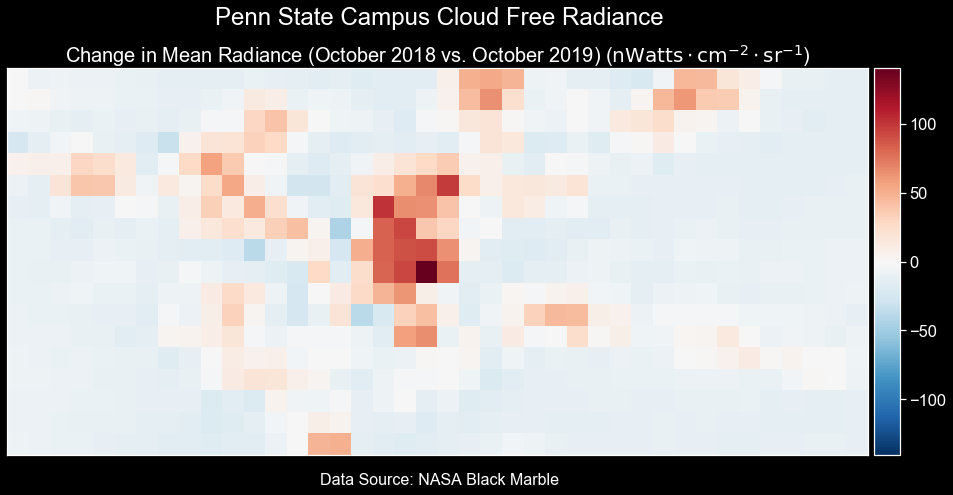

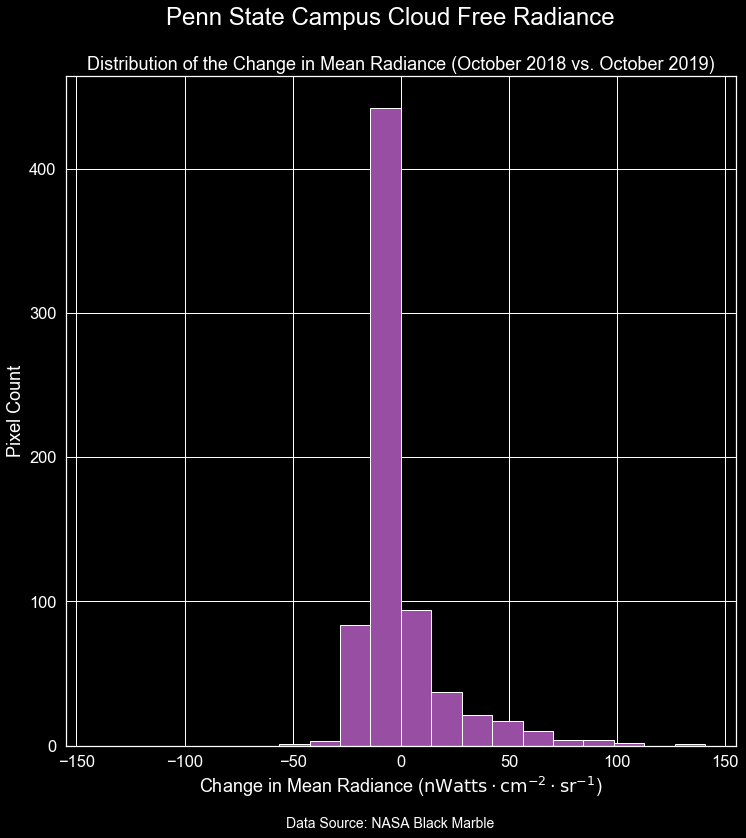

In [73]:
# Calculate October 2018 to October 2019 difference
diff_oct_2018_oct_2019 = rd.subtract_arrays(
    radiance_monthtly_mean.get('2019').get('10'),
    radiance_monthtly_mean.get('2018').get('10'))

# Plot difference
fig, ax = rd.plot_values(
    diff_oct_2018_oct_2019, 
    title="Change in Mean Radiance (October 2018 vs. October 2019)",
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-oct-2018-oct-2019-values.png")

# Save figure as PNG
rd.save_figure(outpath)

# Plot histogram
fig, ax = rd.plot_histogram(
    diff_oct_2018_oct_2019, 
    title="Distribution of the Change in Mean Radiance (October 2018 vs. October 2019)",
    xlabel='Change in Mean Radiance',
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-oct-2018-oct-2019-histogram.png")

# Save figure as PNG
rd.save_figure(outpath)

Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-nov-2018-nov-2019-values.png
Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-nov-2018-nov-2019-histogram.png


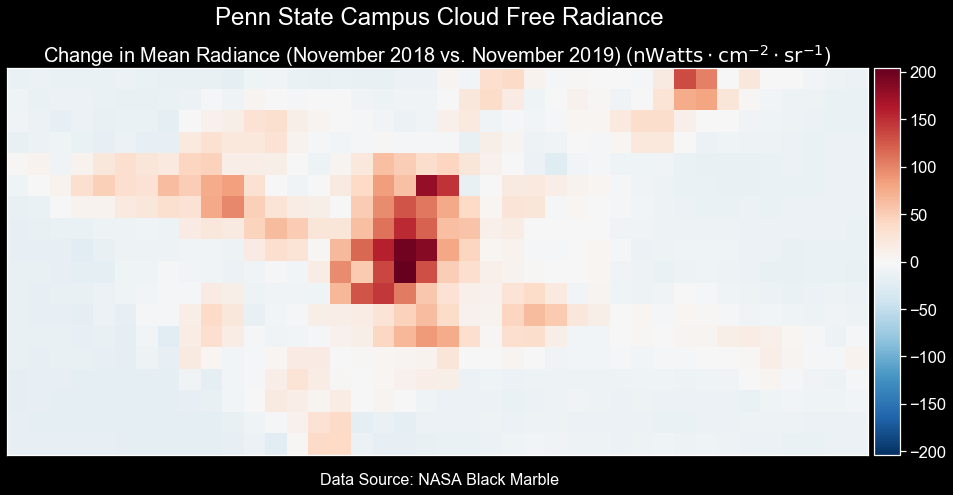

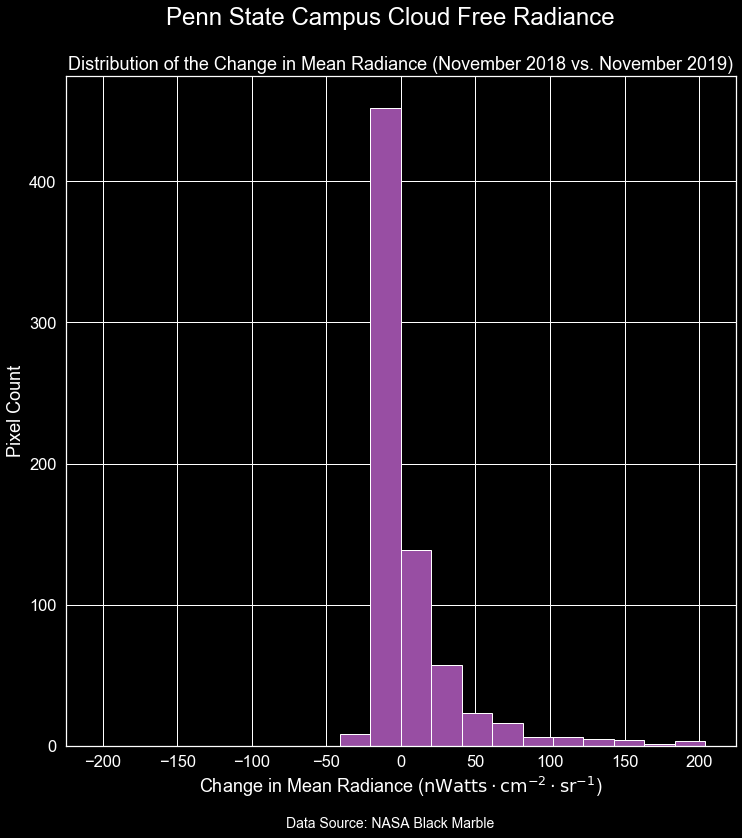

In [74]:
# Calculate November 2018 to November 2019 difference
diff_nov_2018_nov_2019 = rd.subtract_arrays(
    radiance_monthtly_mean.get('2019').get('11'),
    radiance_monthtly_mean.get('2018').get('11'))

# Plot difference
fig, ax = rd.plot_values(
    diff_nov_2018_nov_2019, 
    title="Change in Mean Radiance (November 2018 vs. November 2019)",
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-nov-2018-nov-2019-values.png")

# Save figure as PNG
rd.save_figure(outpath)

# Plot histogram
fig, ax = rd.plot_histogram(
    diff_nov_2018_nov_2019, 
    title="Distribution of the Change in Mean Radiance (November 2018 vs. November 2019)",
    xlabel='Change in Mean Radiance',
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-nov-2018-nov-2019-histogram.png")

# Save figure as PNG
rd.save_figure(outpath)

Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-dec-2018-dec-2019-values.png
Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-dec-2018-dec-2019-histogram.png


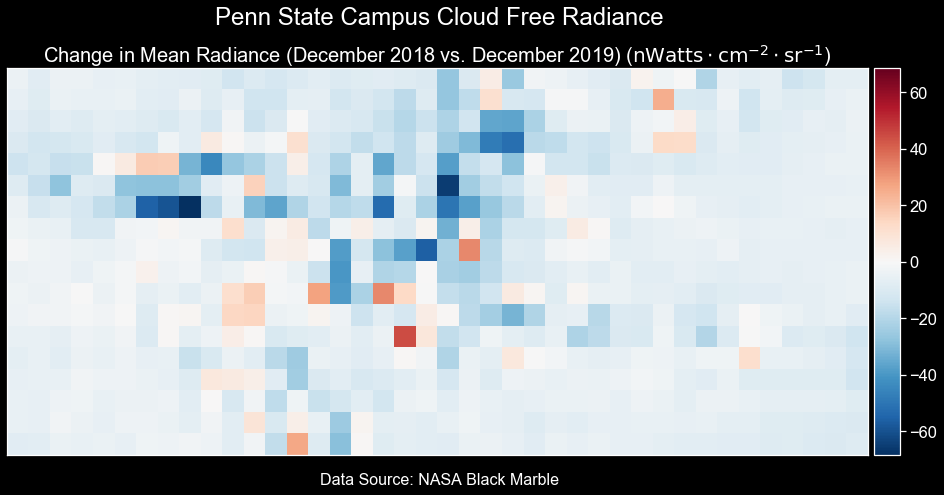

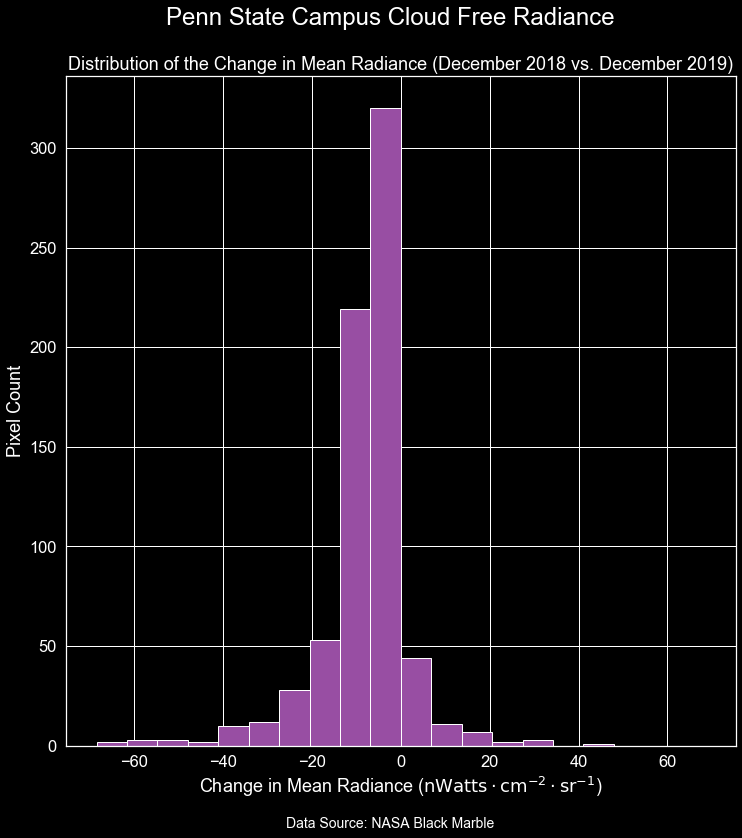

In [75]:
# Calculate December 2018 to December 2019 difference
diff_dec_2018_dec_2019 = rd.subtract_arrays(
    radiance_monthtly_mean.get('2019').get('12'),
    radiance_monthtly_mean.get('2018').get('12'))

# Plot difference
fig, ax = rd.plot_values(
    diff_dec_2018_dec_2019, 
    title="Change in Mean Radiance (December 2018 vs. December 2019)",
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-dec-2018-dec-2019-values.png")

# Save figure as PNG
rd.save_figure(outpath)

# Plot histogram
fig, ax = rd.plot_histogram(
    diff_dec_2018_dec_2019, 
    title="Distribution of the Change in Mean Radiance (December 2018 vs. December 2019)",
    xlabel='Change in Mean Radiance',
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-dec-2018-dec-2019-histogram.png")

# Save figure as PNG
rd.save_figure(outpath)

Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-jan-2019-jan-2020-values.png
Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-jan-2019-jan-2020-histogram.png


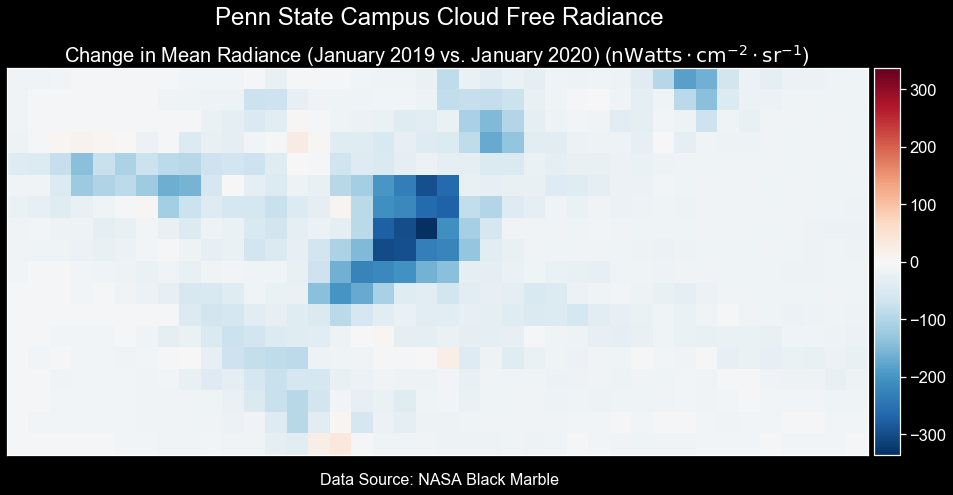

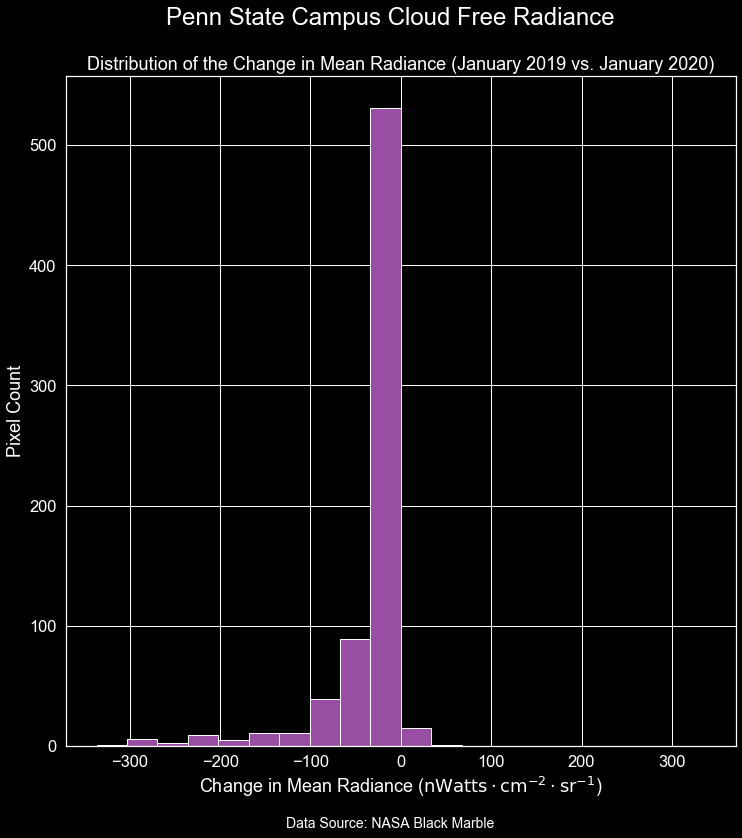

In [76]:
# Calculate January 2019 to January 2020 difference
diff_jan_2019_jan_2020 = rd.subtract_arrays(
    radiance_monthtly_mean.get('2020').get('01'),
    radiance_monthtly_mean.get('2019').get('01'))

# Plot difference
fig, ax = rd.plot_values(
    diff_jan_2019_jan_2020, 
    title="Change in Mean Radiance (January 2019 vs. January 2020)",
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-jan-2019-jan-2020-values.png")

# Save figure as PNG
rd.save_figure(outpath)

# Plot histogram
fig, ax = rd.plot_histogram(
    diff_jan_2019_jan_2020, 
    title="Distribution of the Change in Mean Radiance (January 2019 vs. January 2020)",
    xlabel='Change in Mean Radiance',
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-jan-2019-jan-2020-histogram.png")

# Save figure as PNG
rd.save_figure(outpath)

Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-feb-2019-feb-2020-values.png
Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-feb-2019-feb-2020-histogram.png


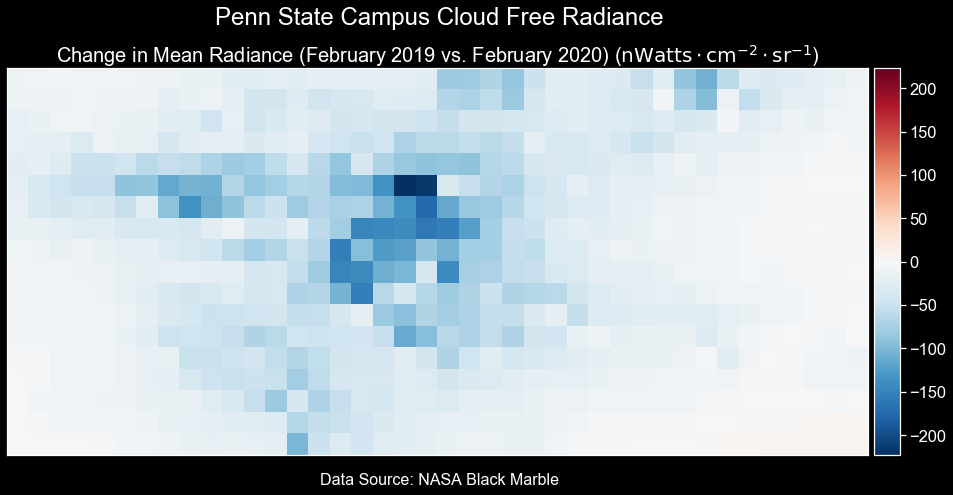

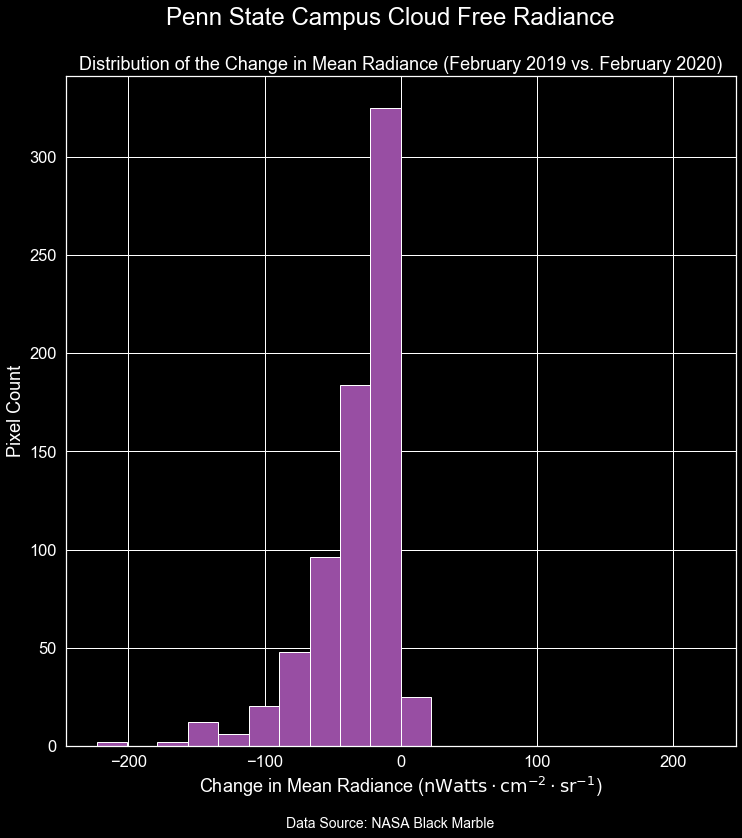

In [77]:
# Calculate February 2019 to February 2020 difference
diff_feb_2019_feb_2020 = rd.subtract_arrays(
    radiance_monthtly_mean.get('2020').get('02'),
    radiance_monthtly_mean.get('2019').get('02'))

# Plot difference
fig, ax = rd.plot_values(
    diff_feb_2019_feb_2020, 
    title="Change in Mean Radiance (February 2019 vs. February 2020)",
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-feb-2019-feb-2020-values.png")

# Save figure as PNG
rd.save_figure(outpath)

# Plot histogram
fig, ax = rd.plot_histogram(
    diff_feb_2019_feb_2020, 
    title="Distribution of the Change in Mean Radiance (February 2019 vs. February 2020)",
    xlabel='Change in Mean Radiance',
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-feb-2019-feb-2020-histogram.png")

# Save figure as PNG
rd.save_figure(outpath)

Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-mar-2019-mar-2020-values.png
Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-mar-2019-mar-2020-histogram.png


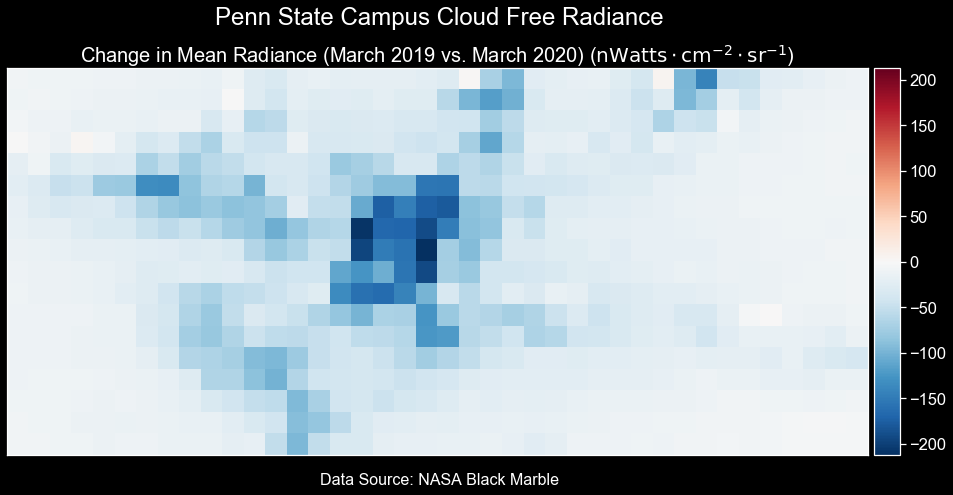

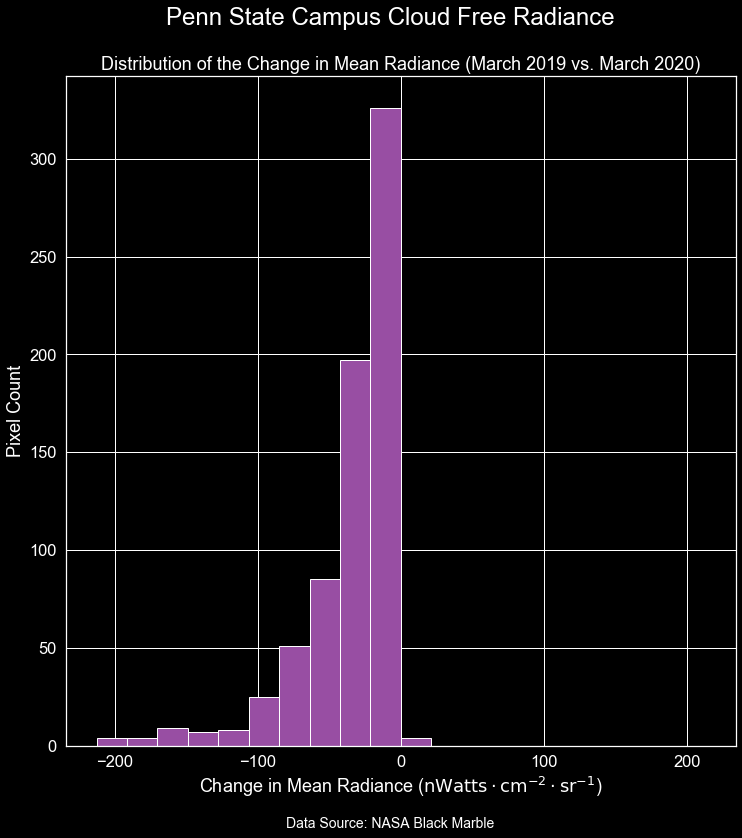

In [81]:
# Calculate March 2019 to March 2020 difference
diff_march_2019_march_2020 = rd.subtract_arrays(
    radiance_monthtly_mean.get('2020').get('03'),
    radiance_monthtly_mean.get('2019').get('03'))

# Plot difference
fig, ax = rd.plot_values(
    diff_march_2019_march_2020, 
    title="Change in Mean Radiance (March 2019 vs. March 2020)",
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-mar-2019-mar-2020-values.png")

# Save figure as PNG
rd.save_figure(outpath)

# Plot histogram
fig, ax = rd.plot_histogram(
    diff_march_2019_march_2020, 
    title="Distribution of the Change in Mean Radiance (March 2019 vs. March 2020)",
    xlabel='Change in Mean Radiance',
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-mar-2019-mar-2020-histogram.png")

# Save figure as PNG
rd.save_figure(outpath)

Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-apr-2019-apr-2020-values.png
Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-apr-2019-apr-2020-histogram.png


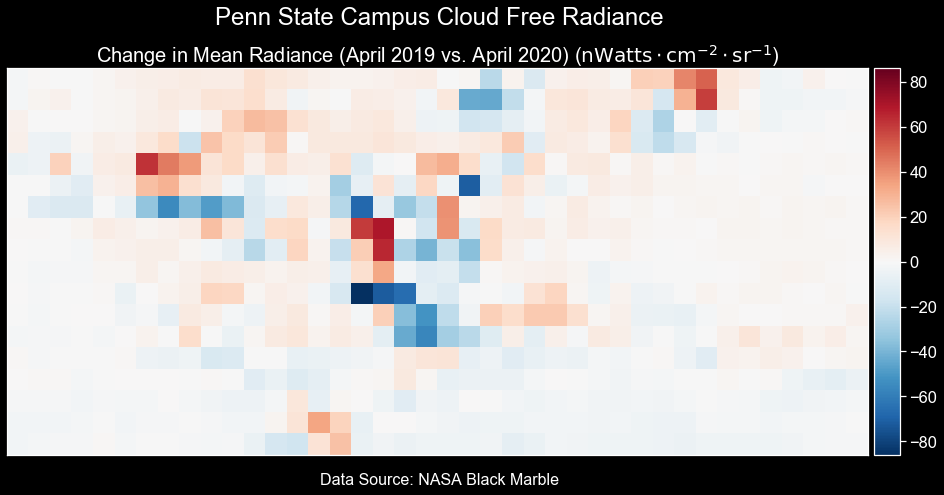

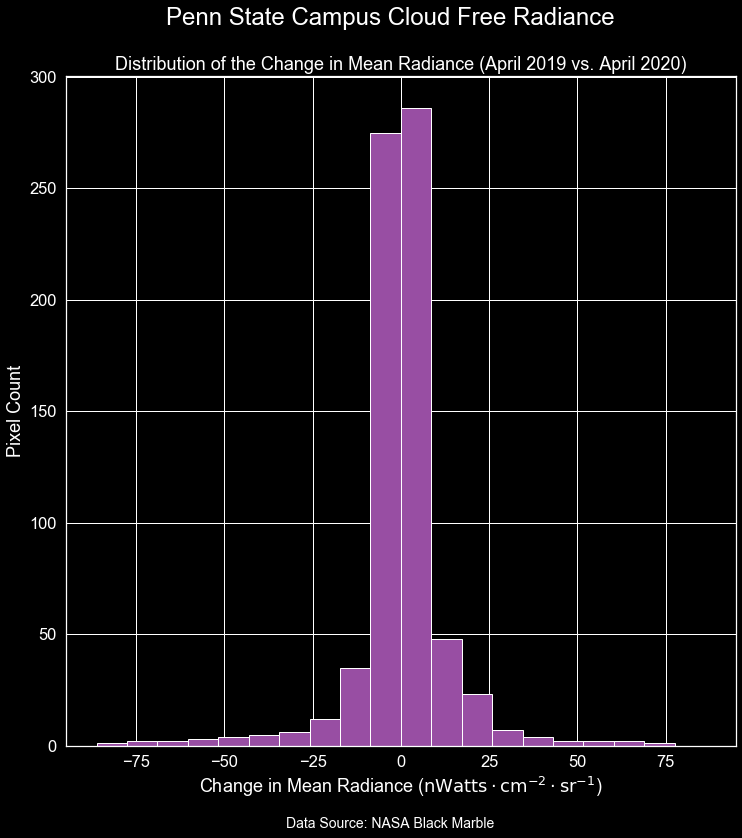

In [82]:
# Calculate April 2019 to April 2020 difference
diff_april_2019_april_2020 = rd.subtract_arrays(
    radiance_monthtly_mean.get('2020').get('04'),
    radiance_monthtly_mean.get('2019').get('04'))

# Plot difference
fig, ax = rd.plot_values(
    diff_april_2019_april_2020, 
    title="Change in Mean Radiance (April 2019 vs. April 2020)",
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-apr-2019-apr-2020-values.png")

# Save figure as PNG
rd.save_figure(outpath)

# Plot histogram
fig, ax = rd.plot_histogram(
    diff_april_2019_april_2020, 
    title="Distribution of the Change in Mean Radiance (April 2019 vs. April 2020)",
    xlabel='Change in Mean Radiance',
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-apr-2019-apr-2020-histogram.png")

# Save figure as PNG
rd.save_figure(outpath)

### Plot and Save Figures to PNG - Weekly Day Mean Difference, 1 Year Gap, Spring Semester

Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-spring-2019-2020-sun-values.png
Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-spring-2019-2020-sun-histogram.png


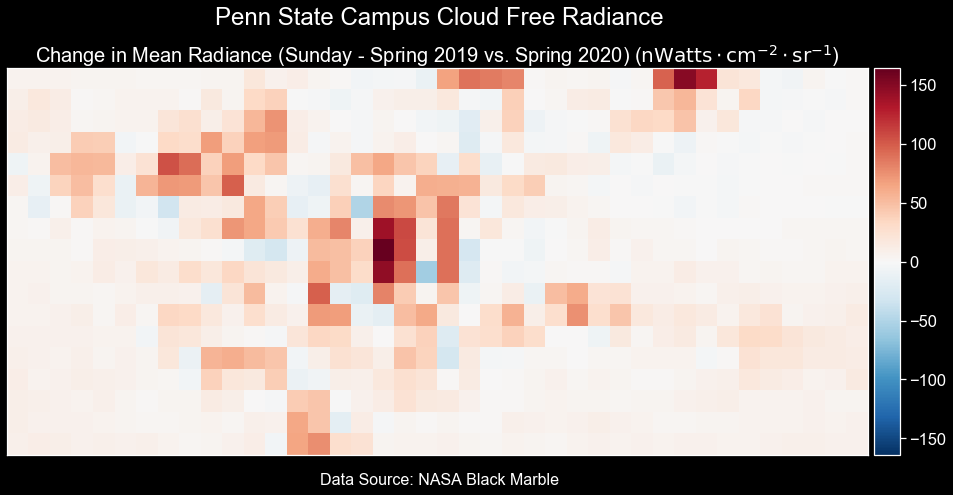

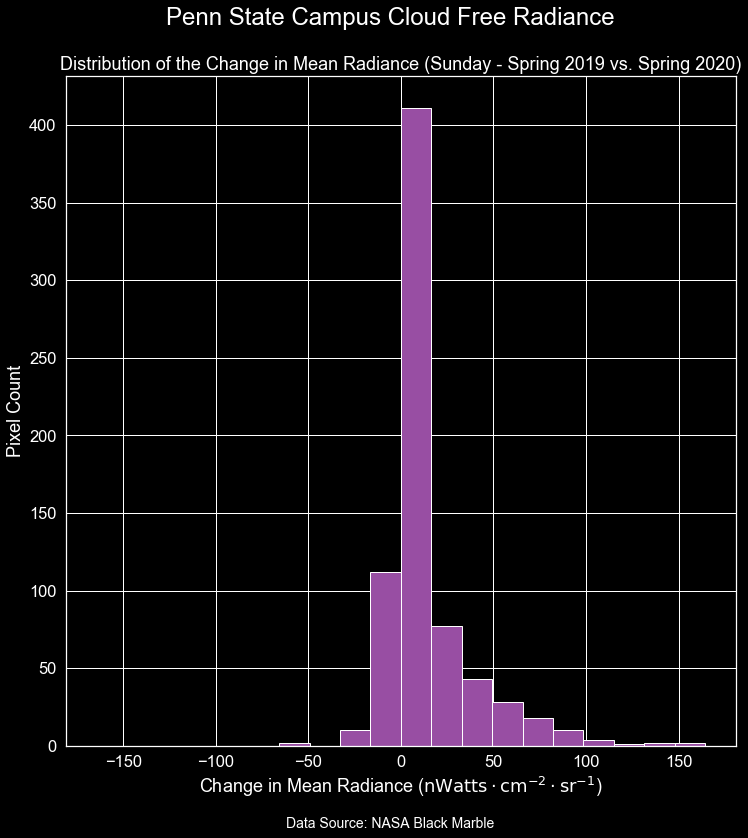

In [91]:
# Get difference between Spring 2019 and Spring 2020 Sunday means
diff_spring_2019_2020_sundays = rd.subtract_arrays(
    semesters_unpacked.get('20200111-20200510-SUN'),
    semesters_unpacked.get('20190105-20190505-SUN'))

# Plot difference
fig, ax = rd.plot_values(
    diff_spring_2019_2020_sundays, 
    title="Change in Mean Radiance (Sunday - Spring 2019 vs. Spring 2020)",
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-spring-2019-2020-sun-values.png")

# Save figure as PNG
rd.save_figure(outpath)

# Plot histogram
fig, ax = rd.plot_histogram(
    diff_spring_2019_2020_sundays, 
    title="Distribution of the Change in Mean Radiance (Sunday - Spring 2019 vs. Spring 2020)",
    xlabel='Change in Mean Radiance',
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-spring-2019-2020-sun-histogram.png")

# Save figure as PNG
rd.save_figure(outpath)

Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-spring-2019-2020-mon-values.png
Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-spring-2019-2020-mon-histogram.png


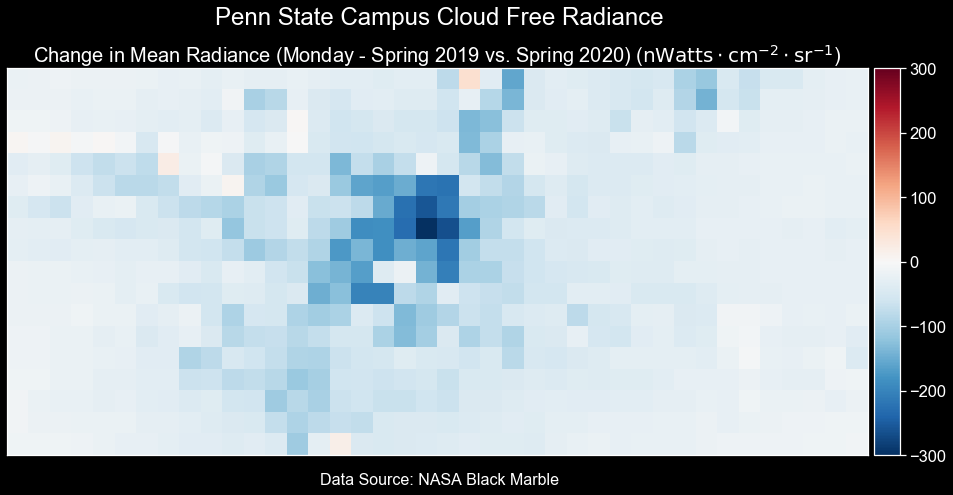

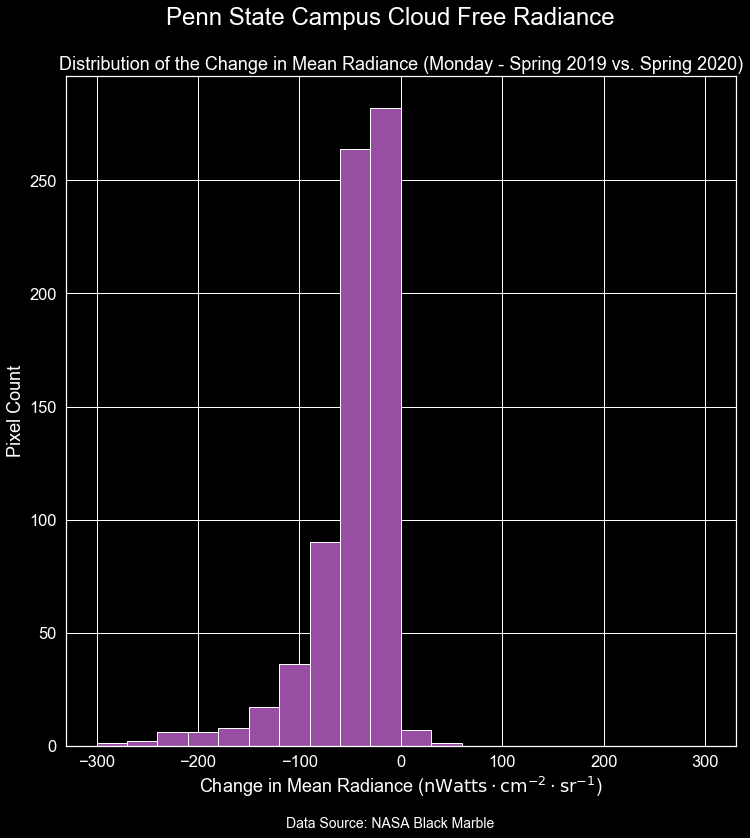

In [93]:
# Get difference between Spring 2019 and Spring 2020 Monday means
diff_spring_2019_2020_mondays = rd.subtract_arrays(
    semesters_unpacked.get('20200111-20200510-MON'),
    semesters_unpacked.get('20190105-20190505-MON'))

# Plot difference
fig, ax = rd.plot_values(
    diff_spring_2019_2020_mondays, 
    title="Change in Mean Radiance (Monday - Spring 2019 vs. Spring 2020)",
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-spring-2019-2020-mon-values.png")

# Save figure as PNG
rd.save_figure(outpath)

# Plot histogram
fig, ax = rd.plot_histogram(
    diff_spring_2019_2020_mondays, 
    title="Distribution of the Change in Mean Radiance (Monday - Spring 2019 vs. Spring 2020)",
    xlabel='Change in Mean Radiance',
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-spring-2019-2020-mon-histogram.png")

# Save figure as PNG
rd.save_figure(outpath)

Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-spring-2019-2020-tue-values.png
Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-spring-2019-2020-tue-histogram.png


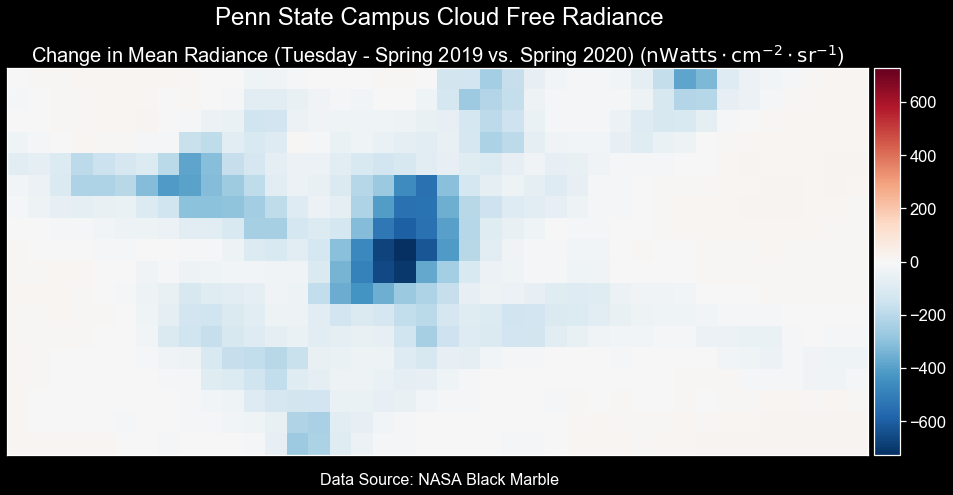

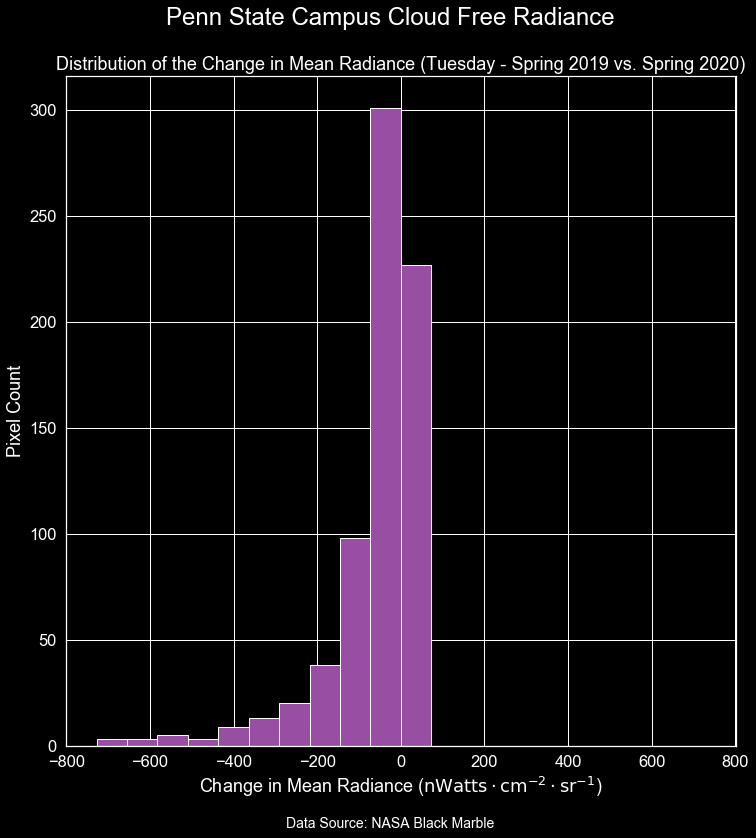

In [94]:
# Get difference between Spring 2019 and Spring 2020 Tuesday means
diff_spring_2019_2020_tuesdays = rd.subtract_arrays(
    semesters_unpacked.get('20200111-20200510-TUE'),
    semesters_unpacked.get('20190105-20190505-TUE'))

# Plot difference
fig, ax = rd.plot_values(
    diff_spring_2019_2020_tuesdays, 
    title="Change in Mean Radiance (Tuesday - Spring 2019 vs. Spring 2020)",
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-spring-2019-2020-tue-values.png")

# Save figure as PNG
rd.save_figure(outpath)

# Plot histogram
fig, ax = rd.plot_histogram(
    diff_spring_2019_2020_tuesdays, 
    title="Distribution of the Change in Mean Radiance (Tuesday - Spring 2019 vs. Spring 2020)",
    xlabel='Change in Mean Radiance',
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-spring-2019-2020-tue-histogram.png")

# Save figure as PNG
rd.save_figure(outpath)

Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-spring-2019-2020-wed-values.png
Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-spring-2019-2020-wed-histogram.png


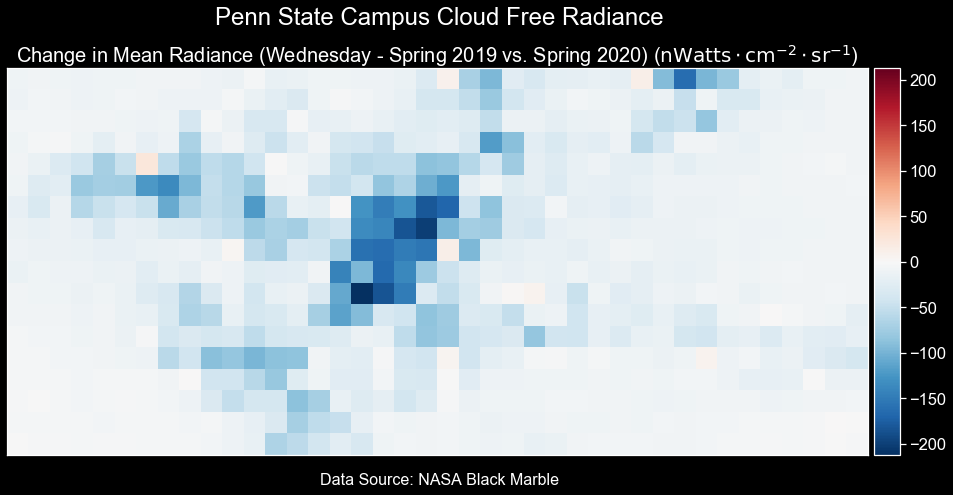

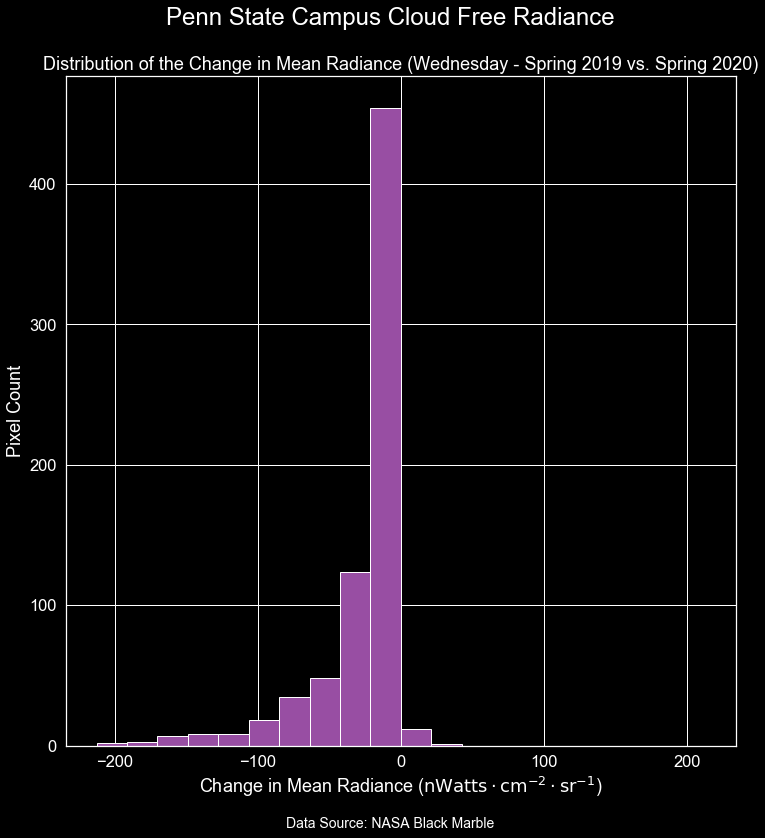

In [95]:
# Get difference between Spring 2019 and Spring 2020 Wednesday means
diff_spring_2019_2020_wednesdays = rd.subtract_arrays(
    semesters_unpacked.get('20200111-20200510-WED'),
    semesters_unpacked.get('20190105-20190505-WED'))

# Plot difference
fig, ax = rd.plot_values(
    diff_spring_2019_2020_wednesdays, 
    title="Change in Mean Radiance (Wednesday - Spring 2019 vs. Spring 2020)",
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-spring-2019-2020-wed-values.png")

# Save figure as PNG
rd.save_figure(outpath)

# Plot histogram
fig, ax = rd.plot_histogram(
    diff_spring_2019_2020_wednesdays, 
    title="Distribution of the Change in Mean Radiance (Wednesday - Spring 2019 vs. Spring 2020)",
    xlabel='Change in Mean Radiance',
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-spring-2019-2020-wed-histogram.png")

# Save figure as PNG
rd.save_figure(outpath)

Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-spring-2019-2020-thu-values.png
Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-spring-2019-2020-thu-histogram.png


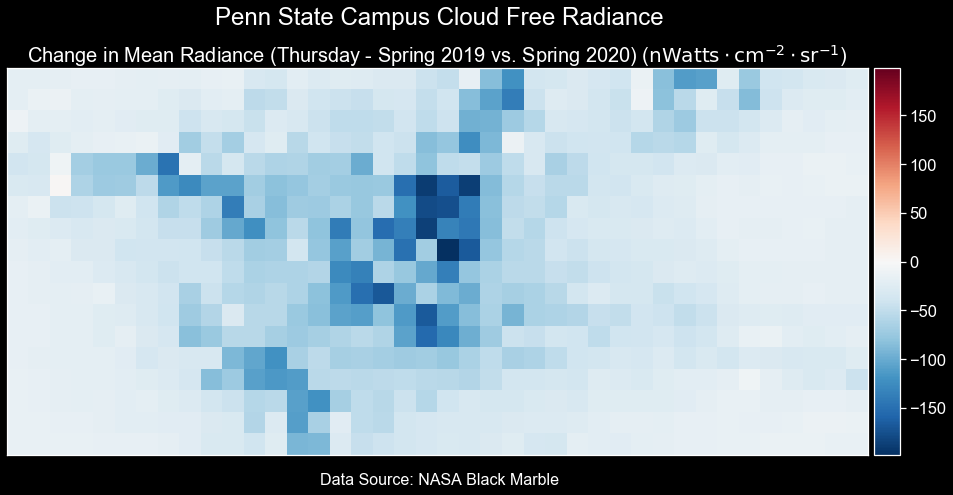

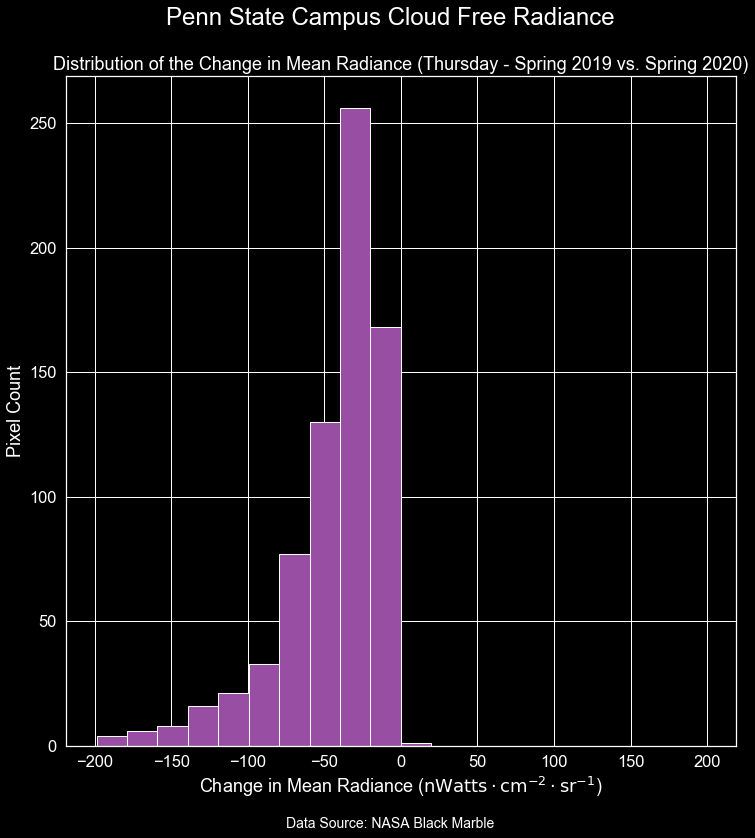

In [96]:
# Get difference between Spring 2019 and Spring 2020 Thursday means
diff_spring_2019_2020_thursdays = rd.subtract_arrays(
    semesters_unpacked.get('20200111-20200510-THU'),
    semesters_unpacked.get('20190105-20190505-THU'))

# Plot difference
fig, ax = rd.plot_values(
    diff_spring_2019_2020_thursdays, 
    title="Change in Mean Radiance (Thursday - Spring 2019 vs. Spring 2020)",
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-spring-2019-2020-thu-values.png")

# Save figure as PNG
rd.save_figure(outpath)

# Plot histogram
fig, ax = rd.plot_histogram(
    diff_spring_2019_2020_thursdays, 
    title="Distribution of the Change in Mean Radiance (Thursday - Spring 2019 vs. Spring 2020)",
    xlabel='Change in Mean Radiance',
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-spring-2019-2020-thu-histogram.png")

# Save figure as PNG
rd.save_figure(outpath)

Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-spring-2019-2020-fri-values.png
Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-spring-2019-2020-fri-histogram.png


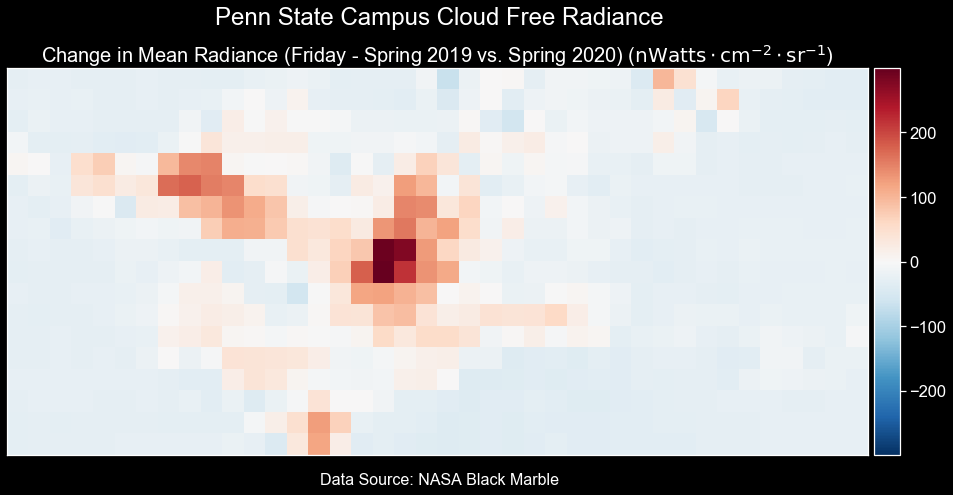

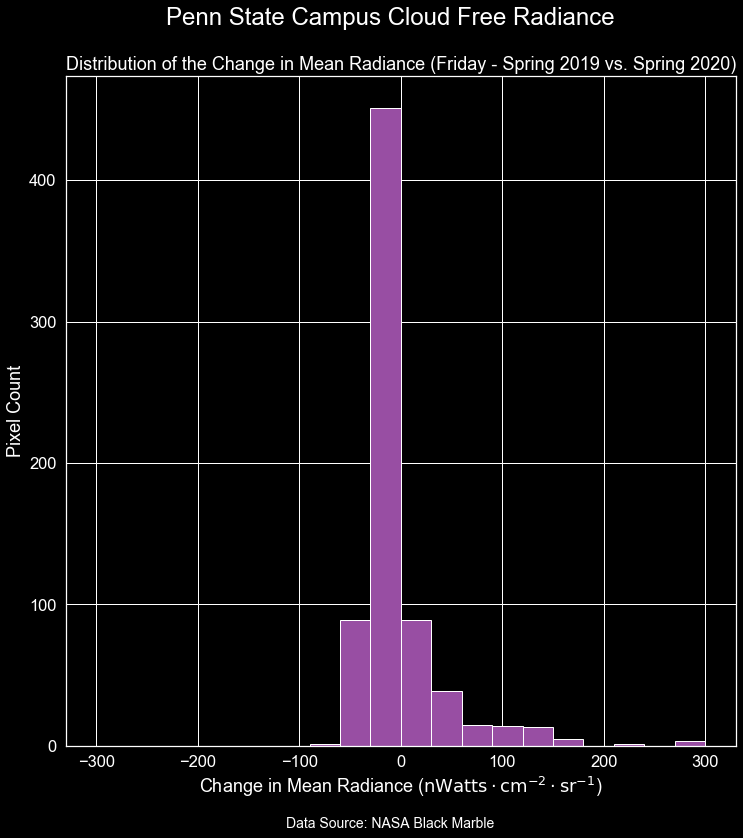

In [98]:
# Get difference between Spring 2019 and Spring 2020 Friday means
diff_spring_2019_2020_fridays = rd.subtract_arrays(
    semesters_unpacked.get('20200111-20200510-FRI'),
    semesters_unpacked.get('20190105-20190505-FRI'))

# Plot difference
fig, ax = rd.plot_values(
    diff_spring_2019_2020_fridays, 
    title="Change in Mean Radiance (Friday - Spring 2019 vs. Spring 2020)",
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-spring-2019-2020-fri-values.png")

# Save figure as PNG
rd.save_figure(outpath)

# Plot histogram
fig, ax = rd.plot_histogram(
    diff_spring_2019_2020_fridays, 
    title="Distribution of the Change in Mean Radiance (Friday - Spring 2019 vs. Spring 2020)",
    xlabel='Change in Mean Radiance',
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-spring-2019-2020-fri-histogram.png")

# Save figure as PNG
rd.save_figure(outpath)

Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-spring-2019-2020-sat-values.png
Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-spring-2019-2020-sat-histogram.png


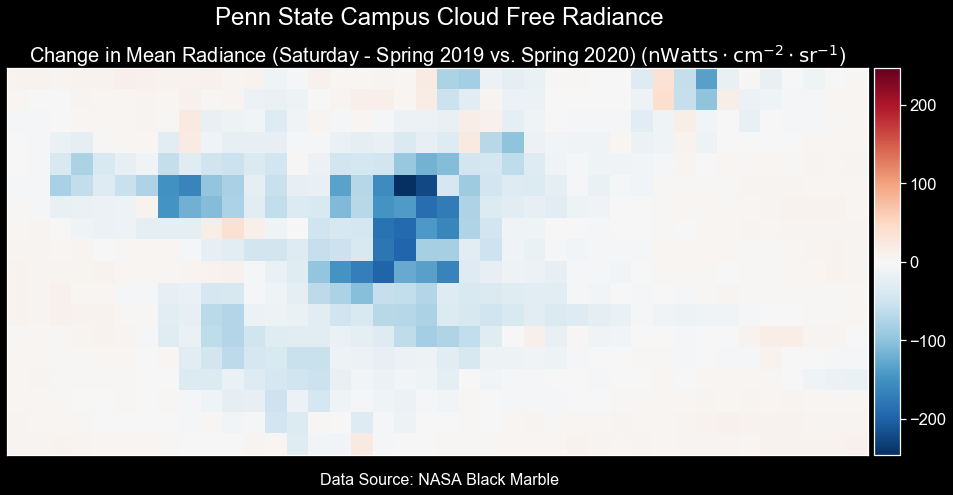

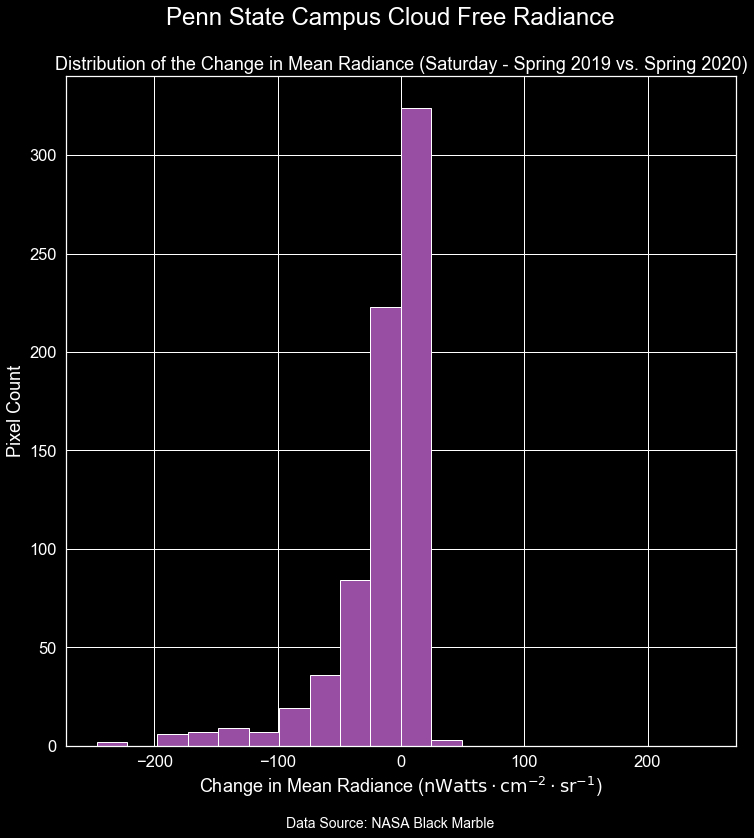

In [100]:
# Get difference between Spring 2019 and Spring 2020 Saturday means
diff_spring_2019_2020_saturdays = rd.subtract_arrays(
    semesters_unpacked.get('20200111-20200510-SAT'),
    semesters_unpacked.get('20190105-20190505-SAT'))

# Plot difference
fig, ax = rd.plot_values(
    diff_spring_2019_2020_saturdays, 
    title="Change in Mean Radiance (Saturday - Spring 2019 vs. Spring 2020)",
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-spring-2019-2020-sat-values.png")

# Save figure as PNG
rd.save_figure(outpath)

# Plot histogram
fig, ax = rd.plot_histogram(
    diff_spring_2019_2020_saturdays, 
    title="Distribution of the Change in Mean Radiance (Saturday - Spring 2019 vs. Spring 2020)",
    xlabel='Change in Mean Radiance',
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-spring-2019-2020-sat-histogram.png")

# Save figure as PNG
rd.save_figure(outpath)

Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-spring-2019-2020-bus-values.png
Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-spring-2019-2020-bus-histogram.png


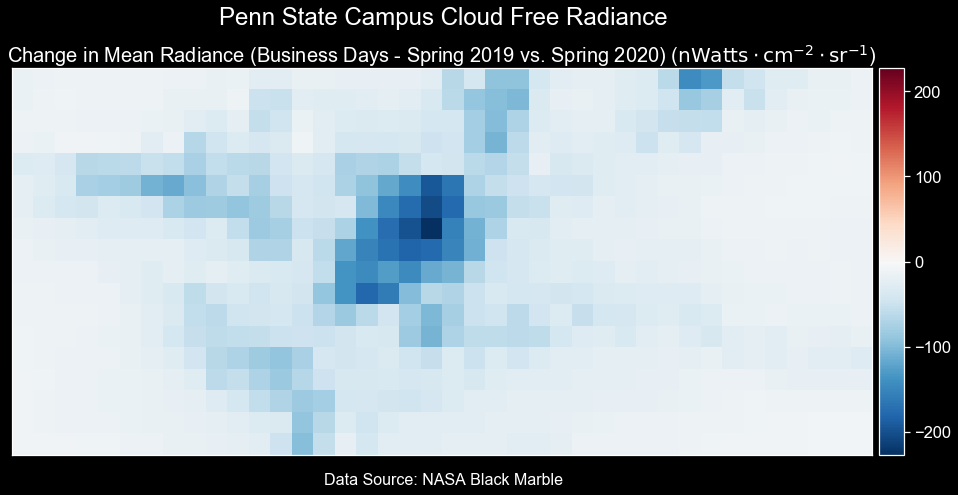

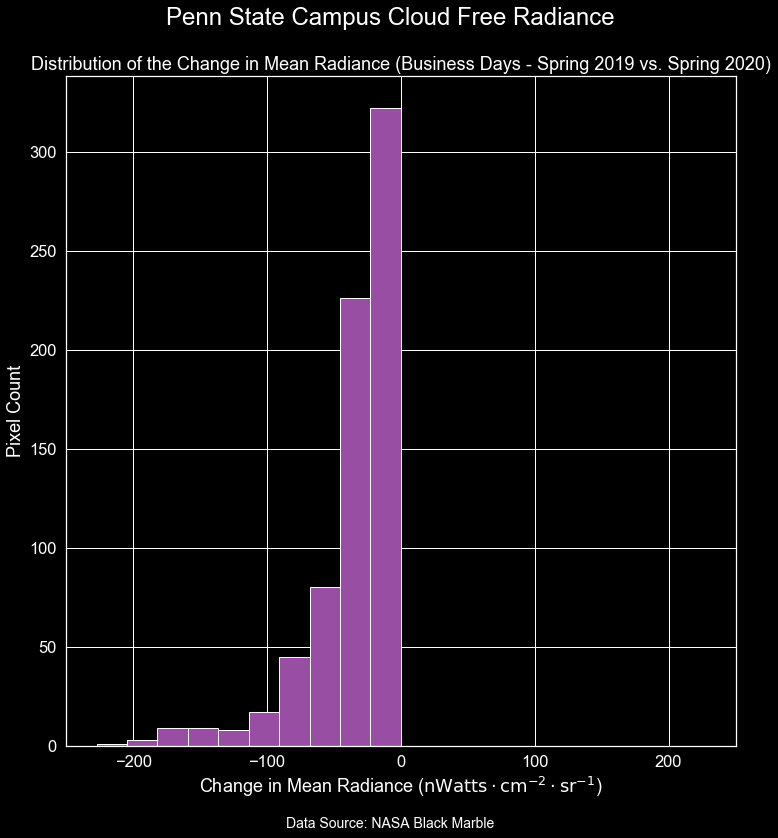

In [101]:
# Get difference between Spring 2019 and Spring 2020 Business Day means
diff_spring_2019_2020_business = rd.subtract_arrays(
    semesters_unpacked.get('20200111-20200510-BUS'),
    semesters_unpacked.get('20190105-20190505-BUS'))

# Plot difference
fig, ax = rd.plot_values(
    diff_spring_2019_2020_business, 
    title="Change in Mean Radiance (Business Days - Spring 2019 vs. Spring 2020)",
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-spring-2019-2020-bus-values.png")

# Save figure as PNG
rd.save_figure(outpath)

# Plot histogram
fig, ax = rd.plot_histogram(
    diff_spring_2019_2020_business, 
    title="Distribution of the Change in Mean Radiance (Business Days - Spring 2019 vs. Spring 2020)",
    xlabel='Change in Mean Radiance',
    difference=True)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-spring-2019-2020-bus-histogram.png")

# Save figure as PNG
rd.save_figure(outpath)

### Plot Single-Pixel Radiance Values

In [ ]:
# # Get radiance data for one pixel (Sept 2019 - April 2020)
# pixel_id_0_radiance = psu_radiance_filled.loc[0]

In [ ]:
# # Get cloud mask data for one pixel (Sept 2019 - April 2020)
# pixel_id_0_mask = psu_cloud_mask_filled.loc[[0]]

In [ ]:
# # Plot single-pixel time series
# with plt.style.context('dark_background'):
    
#     ax = pixel_id_0_radiance.plot(figsize=(16,6), grid=False, color='#ff7f00', linewidth=2)
    
#     ax.set_title('Penn State Campus - Single-Pixel Time Series\nPixel ID 0 - Longitude: -77.937355, Latitude: 40.829917')
#     ax.set_xlabel('Date')
#     ax.set_ylabel('Unmasked Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)')

### Combined Plots

Function that plots change - plots two input arrays, and the change in a combined plot.

```python
def plot_change(post_change, pre_change):
    """
    """
    pass
```

```python
def plot_values_histogram(radiance):
    """
    """
    pass
```

In [113]:
# def plot_change(pre_change, post_change, location='Penn State Campus', 
#                 titles=['Radiance', 'Radiance', 'Radiance'], 
#                 data_source='NASA Black Marble'):
#     """Plots two arrays and the difference
#     between the arrays on the same figure.

#     pre_change : numpy array
#         Numpy array containing radiance values.

#     post_change : numpy array
#         Numpy array containing radiance values.
        
#     location : str, optional
#         Name of study area location. Included in plot
#         super-title. Default value is 'Penn State Campus'.

#     titles : list of str, optional
#         Plot sub-titles. Default value is ['Radiance',
#         'Radiance', 'Radiance']. Intended for ['September 
#         2019 Mean Radiance', 'March 2020 Mean Radiance',
#        'Change in Mean Radiance (September 2019 vs. March 
#        2020)'].

#     data_source : str, optional
#         Sources of data used in the plot.
#         Default value is 'NASA Black Marble'.

#     Returns
#     -------
#     tuple

#         fig : matplotlib.figure.Figure object
#             The figure object associated with the histogram.

#         ax : matplotlib.axes._subplots.AxesSubplot objects
#             The axes objects associated with the histogram.

#     Example
#     -------
#         >>> # Define titles
#         >>> plot_titles = [
#         ...     'September 2019 Mean Radiance',
#         ...     'March 2020 Mean Radiance',
#         ...     'Change in Mean Radiance (September 2019 vs. March 2020)'
#         ... ]
#         >>> # Plot Sept 2019 and March 2020
#         >>> fig, ax = plot_change(
#         >>>     pre_change=radiance_monthtly_mean.get('2019').get('09'),
#         >>>     post_change=radiance_monthtly_mean.get('2020').get('03'),
#                 titles=plot_titles)
#     """
#     # Find max radiance values in pre-change and post-change
#     pre_change_max = np.absolute(pre_change.max())
#     post_change_max = np.absolute(post_change.max())

#     # Define vmin/vmax for radiance values
#     value_vmin = 0
    
#     value_vmax = pre_change_max if (
#         pre_change_max > post_change_max) else post_change_max
    
#     # Calculate difference (post-change - pre-change)
#     diff = rd.subtract_arrays(post_change, pre_change)
       
#     # Find absolute values for change min & max
#     diff_min_abs = np.absolute(diff.min())
#     diff_max_abs = np.absolute(diff.max())

#     # Determine max value (for plotting vmin/vmax)
#     diff_vmax = diff_min_abs if (
#         diff_min_abs > diff_max_abs) else diff_max_abs
    
#     diff_vmin = -diff_vmax  
    
#     # Define radiance units
#     units = "$\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$"
    
#     # Define titles
#     pre_change_title = f"{titles[0]} ({units})"
#     post_change_title = f"{titles[1]} ({units})"
#     diff_title = f"{titles[2]} ({units})"
    
#     # Define color maps
#     value_cmap = 'Greys_r'
#     diff_cmap = 'RdBu_r'
    
#     # Use dark background
#     with plt.style.context('dark_background'):
    
#         # Create figure and axes objects
#         fig, ax = plt.subplots(3, 1, figsize=(30, 20))
    
#         # Add super title
#         plt.suptitle(f"{location} Cloud Free Radiance", size=24)
 
#         # Adjust spacing
#         plt.subplots_adjust(hspace=0.15)
#         plt.subplots_adjust(top=0.925)
    
#         # Plot pre-change array
#         ep.plot_bands(
#             pre_change, 
#             scale=False,
#             title=pre_change_title,
#             vmin=value_vmin,
#             vmax=value_vmax,
#             cmap=value_cmap,
#             ax=ax[0])
        
#         # Plot post-change array
#         ep.plot_bands(
#             post_change, 
#             scale=False,
#             title=post_change_title,
#             vmin=value_vmin,
#             vmax=value_vmax,
#             cmap=value_cmap,
#             ax=ax[1])
        
#         # Plot diff array
#         ep.plot_bands(
#             diff, 
#             scale=False,
#             title=diff_title,
#             vmin=diff_vmin,
#             vmax=diff_vmax,
#             cmap=diff_cmap,
#             ax=ax[2])    
    
#         # Add caption
#         fig.text(0.5, .1, f"Data Source: {data_source}",
#                  ha='center', fontsize=16)
    
#         # Set title size
#         ax[0].title.set_size(20)
#         ax[1].title.set_size(20)
#         ax[2].title.set_size(20)
    
#     # Return figure and axes object
#     return fig, ax

Saved plot: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-sep-2019-mar-2020-values-all.png


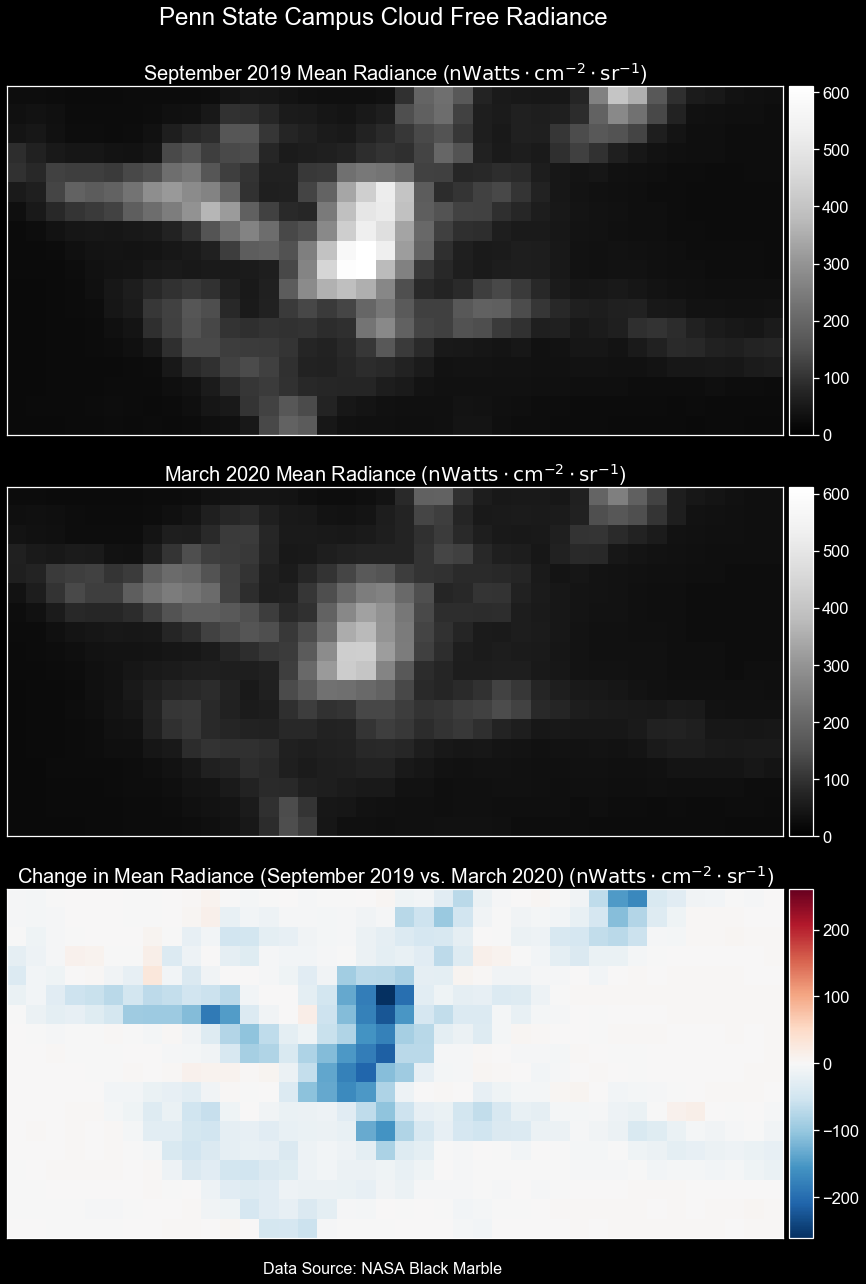

In [116]:
# Define titles
plot_titles = [
    'September 2019 Mean Radiance',
    'March 2020 Mean Radiance',
    'Change in Mean Radiance (September 2019 vs. March 2020)'
]

# Plot Sept 2019 and March 2020
fig, ax = rd.plot_change(
    pre_change=radiance_monthtly_mean.get('2019').get('09'),
    post_change=radiance_monthtly_mean.get('2020').get('03'),
    titles=plot_titles)

# Define output path
outpath = os.path.join(
    working_directory, "04-graphics-outputs", 
    "penn-state-campus-radiance-difference-sep-2019-mar-2020-values-all.png")

# Save figure as PNG
rd.save_figure(outpath)

In [ ]:
# Plot
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(3, 1, figsize=(30, 20))

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    plt.subplots_adjust(hspace=0.15)
    plt.subplots_adjust(top=0.9)

    ep.plot_bands(
        radiance_monthtly_mean.get('2019').get('09'), title="September 2019 Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
        scale=False,
        vmax=radiance_monthtly_mean.get('2019').get('09').max(),
        ax=ax[0],
        extent=psu_extent)

    ep.plot_bands(
        radiance_monthtly_mean.get('2020').get('03'), title="March 2020 Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
        scale=False,
        vmax=radiance_monthtly_mean.get('2019').get('09').max(),
        ax=ax[1],
        extent=psu_extent)

    ep.plot_bands(
        diff_sept_2019_march_2020, title="Change in Mean Radiance (September 2019 vs. March 2020) ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
        cmap='RdBu_r',
        scale=False,
        vmin=diff_sept_2019_march_2020.min(),
        vmax=-diff_sept_2019_march_2020.min(),
        ax=ax[2],
        extent=psu_extent)

    # Add caption
    fig.text(0.5, .1, "Data Source: NASA Black Marble",
             ha='center', fontsize=16)
    
    ax[0].title.set_size(20)
    ax[1].title.set_size(20)
    ax[2].title.set_size(20)

plt.savefig(
    fname="penn-state-mean-radiance-change-sept2019-mar2020-values.png", 
    facecolor='k', dpi=300, transparent=True, bbox_inches='tight')

In [ ]:
# Histogram
with plt.style.context('dark_background'):
    fig, ax = ep.hist(
        diff_sept_2019_march_2020,
        #         bins=40,
        hist_range=(diff_sept_2019_march_2020.min(), -diff_sept_2019_march_2020.min()),
        colors='#984ea3',
        title='Distribution of the Change in Mean Radiance (September 2019 vs. March 2020)',
        xlabel='Change in Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)', ylabel='Pixel Count')

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    # Add caption
    fig.text(0.5, .03, "Data Source: NASA Black Marble",
             ha='center', fontsize=14)

plt.savefig(
    fname="penn-state-mean-radiance-change-sept2019-mar2020-histogram.png", 
    facecolor='k', dpi=300, transparent=True, bbox_inches='tight')

## Data Export

In [102]:
# Define export output paths
sept_2019_radiance_outpath = os.path.join(
    working_directory, "04-graphics-outputs",
    "penn-state-campus-radiance-sept-2019.tif")

march_2020_radiance_outpath = os.path.join(
    working_directory, "04-graphics-outputs",
    "penn-state-campus-radiance-march-2020.tif")

radiance_diff_outpath = os.path.join(
    working_directory, "04-graphics-outputs",
    "penn-state-campus-radiance-difference-sept-2019-march-2020.tif")

In [104]:
# Define export metadata
psu_campus_metadata = rd.create_metadata(
    array=diff_sep_2019_march_2020, transform=psu_transform)

In [106]:
# Export September 2019 radiance
rd.export_array(
    array=radiance_monthtly_mean.get('2019').get('09'),
    output_path=sept_2019_radiance_outpath,
    metadata=psu_campus_metadata)

# Export March 2020 radiance
rd.export_array(
    array=radiance_monthtly_mean.get('2020').get('03'),
    output_path=march_2020_radiance_outpath,
    metadata=psu_campus_metadata)

# Export radiance difference
rd.export_array(
    array=diff_sep_2019_march_2020,
    output_path=radiance_diff_outpath,
    metadata=psu_campus_metadata)

Exported C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-sept-2019.tif
Exported C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-march-2020.tif
Exported C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\remote-sensing-fusion\04-graphics-outputs\penn-state-campus-radiance-difference-sept-2019-march-2020.tif
